<a href="https://colab.research.google.com/github/arijit780/BTP/blob/master/updated_13_09.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [14]:
from google.colab import drive
drive.mount('/content/drive',force_remount=True)

MessageError: ignored

In [15]:
import numpy as np
import pandas as pd
import seaborn as sns
import scipy.io
import os
import matplotlib.pyplot as plt
from scipy.stats import entropy,lognorm
from scipy.signal import hilbert, periodogram, butter, sosfilt, spectrogram
from scipy import signal

!unzip "/content/drive/MyDrive/nasaT2-20230816T171611Z-001.zip" -d "/content/IMS-3"

#!ls /content/
# path = '/kaggle/input/bearing-dataset/2nd_test/2nd_test/2004.02.12.10.32.39'


Archive:  /content/drive/MyDrive/nasaT2-20230816T171611Z-001.zip
replace /content/IMS-3/nasaT2/2004.02.19.05.02.txt? [y]es, [n]o, [A]ll, [N]one, [r]ename: A
  inflating: /content/IMS-3/nasaT2/2004.02.19.05.02.txt  
  inflating: /content/IMS-3/nasaT2/2004.02.19.06.22.txt  
  inflating: /content/IMS-3/nasaT2/2004.02.19.03.32.txt  
  inflating: /content/IMS-3/nasaT2/2004.02.19.01.52.txt  
  inflating: /content/IMS-3/nasaT2/2004.02.19.03.12.txt  
  inflating: /content/IMS-3/nasaT2/2004.02.19.06.12.txt  
  inflating: /content/IMS-3/nasaT2/2004.02.19.01.12.txt  
  inflating: /content/IMS-3/nasaT2/2004.02.19.03.22.txt  
  inflating: /content/IMS-3/nasaT2/2004.02.19.03.52.txt  
  inflating: /content/IMS-3/nasaT2/2004.02.19.00.52.txt  
  inflating: /content/IMS-3/nasaT2/2004.02.19.05.42.txt  
  inflating: /content/IMS-3/nasaT2/2004.02.19.05.32.txt  
  inflating: /content/IMS-3/nasaT2/2004.02.19.04.42.txt  
  inflating: /content/IMS-3/nasaT2/2004.02.19.02.42.txt  
  inflating: /content/IMS-3/nas

In [19]:
path = '/content/IMS-3/nasaT2'  # Adjust based on your actual path

In [18]:
 #Define functions to compute skewness and kurtosis
from scipy.stats import weibull_min, norm

def compute_skewness(data):
    return ((np.mean(data**3)) / (np.mean(data**2))**(3/2))

def compute_kurtosis(data):
    return ((np.mean(data**4)) / (np.mean(data**2))**2)
def weibull_log_likelihood(data):
    shape, loc, scale = weibull_min.fit(data, floc=0)
    pdf_values = weibull_min.pdf(data, shape, loc, scale)
    epsilon = 1e-10
    log_likelihood = np.sum(np.log(pdf_values + epsilon))
    return -log_likelihood

def gaussian_log_likelihood(data):
    mu, std = np.mean(data), np.std(data)
    pdf_values = norm.pdf(data, mu, std)
    epsilon = 1e-10
    log_likelihood = np.sum(np.log(pdf_values + epsilon))
    return -log_likelihood
'''
def extract_features(signal_data):
    feature_vector = np.zeros(11)
     # Time-domain features
    feature_vector[0] = np.max(signal_data)
    feature_vector[1] = np.min(signal_data)
    feature_vector[2] = np.mean(signal_data)
    feature_vector[3] = np.std(signal_data, ddof=1)
    feature_vector[4] = np.sqrt(np.mean(signal_data**2))
    feature_vector[5] = compute_skewness(signal_data)
    feature_vector[6] = compute_kurtosis(signal_data)
    feature_vector[7] = feature_vector[0]/feature_vector[4]
    absolute_energy = np.sum(np.square(signal_data)) / len(signal_data)
    feature_vector[8] = absolute_energy

    # Envelope analysis
    analytic_signal = hilbert(signal_data)
    amplitude_envelope = np.abs(analytic_signal)
    global_value = np.max(amplitude_envelope) - np.min(amplitude_envelope)
    feature_vector[9] = global_value

    # Principal frequency
    freqs, psd = periodogram(signal_data)
    principal_frequency = freqs[np.argmax(psd)]
    feature_vector[10] = principal_frequency

    return feature_vector'''
'''def renyi_entropy(data, alpha):
    p_data = np.abs(data) / np.sum(np.abs(data), axis=0)  # Normalize the data
    return np.log(np.sum(p_data**alpha, axis=0)) / (1 - alpha)'''
def renyi_entropy(data, alpha):
    epsilon = 1e-10
    p_data = np.abs(data + epsilon) / np.sum(np.abs(data + epsilon), axis=0)  # Normalize the data and avoid zeros
    return np.log(np.sum(p_data**alpha, axis=0)) / (1 - alpha)


In [20]:
def s_transform(x, t, fmin=0, fmax=None, nf=None):
    """Compute the S-Transform of a signal x"""
    dt = t[1] - t[0]
    N = len(t)

    if fmax is None:
        fmax = 0.5 / dt
    if nf is None:
        nf = N

    f = np.linspace(fmin, fmax, nf)

    X = np.fft.fft(x)
    omega = 2 * np.pi * np.fft.fftfreq(N, dt)

    ST = np.zeros((nf, N), dtype=complex)

    for i, fi in enumerate(f):
        if fi == 0:  # Skip the computation for zero frequency
            continue
        width = 0.1 / (2 * np.pi * fi)
        window = np.exp(-width ** 2 * omega ** 2 / 2)
        ST[i, :] = np.fft.ifft(X * window)

    return f, ST

In [21]:
# List all files in the directory
#file_list = os.listdir(path)


# Define batch size
#batch_size = 10  # Adjust this based on your available memory

# Initialize a DataFrame to store the results
All_new_feature_matrix = pd.DataFrame()


In [22]:

# Sample vibration data
'''
for i in range(0, len(file_list), batch_size):
  batch_files = file_list[i:i+batch_size]
  batch_feature_matrix = pd.DataFrame()
  #print(All_new_feature_matrix)
  for filename in batch_files:'''
# Low-pass filter setup
fs = 20480 # You need to specify the correct sampling frequency here
nyquist_freq = fs / 2
cutoff_freq = 5000
sos = signal.butter(10, cutoff_freq/nyquist_freq, btype='lowpass', output='sos')
for filename in os.listdir(path):
    dataset = pd.read_csv(os.path.join(path, filename), sep='\t', header=None)
    vibration_data = np.array(dataset.iloc[:, 2])  # Adjusted to 2 to select the third column
    # ... (rest of your code)
    print(len(vibration_data), filename, 2)
    # Apply low-pass filter
    filtered_vibration_data = signal.sosfilt(sos, vibration_data)
    # S-Transform
    t = np.linspace(0, 1, 20480)
    frequencies, ST = s_transform(filtered_vibration_data, t,nf=100)
    reconstructed_signal = np.real(np.sum(ST, axis=0))

 #Feature extraction
    feature_matrix = np.zeros((1, 38))  # Adjusted to 30 to include all features
    temp = reconstructed_signal

    # Time features
    feature_matrix[0, 0] = np.max(temp)#max value
    feature_matrix[0, 1] = np.min(temp)
    feature_matrix[0, 2] = np.mean(temp)
    feature_matrix[0, 3] = np.std(temp, ddof=1)
    feature_matrix[0, 4] = np.sqrt(np.mean(temp**2))
    feature_matrix[0, 5] = compute_skewness(temp)
    feature_matrix[0, 6] = compute_kurtosis(temp)
    feature_matrix[0, 7] = np.max(np.abs(temp)) - np.min(np.abs(temp))
    absolute_energy = np.sum(np.square(temp)) / len(temp)
    feature_matrix[0, 8] = absolute_energy

    # Envelope analysis
    analytic_signal = hilbert(temp)
    amplitude_envelope = np.abs(analytic_signal)
    global_value = np.max(amplitude_envelope) - np.min(amplitude_envelope)
    feature_matrix[0, 9] = global_value

    # Principal frequency
    freqs, psd = periodogram(temp)
    principal_frequency = freqs[np.argmax(psd)]
    feature_matrix[0, 10] = principal_frequency

    # Additional features (T11 to T30)
    feature_matrix[0, 11] = np.percentile(temp, 25)  # 25th percentile (T8)
    feature_matrix[0, 12] = np.percentile(temp, 50)  # Median (T7)
    feature_matrix[0, 13] = np.percentile(temp, 75)  # 75th percentile (T9)
    #feature_matrix[0, 14] =
    feature_matrix[0, 14] = np.var(temp)  # Activity (T26)
    feature_matrix[0, 15] = np.std(np.diff(temp)) / np.std(temp)  # Mobility (T27)
    feature_matrix[0, 16] = np.std(np.diff(np.diff(temp))) / np.std(np.diff(temp))  # Complexity (T28)
  # standard Complexity (T28)
    feature_matrix[0, 17] = np.sum(temp[:-1] * temp[1:] < 0) / len(temp)  # Rate of zero crossing (T22)
    feature_matrix[0, 18] = entropy(temp)  # Entropy (T23)

    # Histogram bounds (T24 and T25)
    N = len(temp)
    feature_matrix[0, 19] = np.max(temp) + ((np.max(temp) - np.min(temp)) / (N - 1)) / 2  # Histogram upper bound (T24)
    feature_matrix[0, 20] = np.max(temp) - ((np.max(temp) - np.min(temp)) / (N - 1)) / 2  # Histogram lower bound (T25)
    feature_matrix[0,21]=weibull_log_likelihood(temp);
    feature_matrix[0,22]=gaussian_log_likelihood(temp);
    # Calculate Rényi entropy for different values of alpha
    alphas = [0.1, 0.5, 1.0, 2.0]
    renyi_entropies = []

    for alpha in alphas:
        renyi_entropy = entropy(temp,alpha)#natural log so base=none i.e e
        renyi_entropies.append(renyi_entropy)

    # Add Rényi entropies to the feature matrix
    feature_matrix[0, 23:27] = renyi_entropies #renyi entropies

    rms_value = np.sqrt(np.mean(temp**2))
    mean_absolute_values = np.mean(np.abs(temp))
    mean_squared_values = np.mean(np.square(temp))

    feature_matrix[0, 27] = np.max(temp) / rms_value  # Crest Factor
    feature_matrix[0, 28] = rms_value / mean_absolute_values  # Shape Factor
    feature_matrix[0, 29] = np.max(temp) / mean_absolute_values  # Impulse Factor
    feature_matrix[0, 30] = np.max(temp) / (mean_squared_values**(1/4))  # Clearance Factor
    feature_matrix[0, 31] = compute_skewness(temp) / np.std(temp, ddof=1)  # Skewness Factor
    feature_matrix[0, 32] = compute_kurtosis(temp) / (np.std(temp, ddof=1)**2)  # Kurtosis Factor
    feature_matrix[0, 33] = np.exp(np.mean(np.log(temp[temp>0])))  # Geometric Mean, avoiding zeros
    feature_matrix[0, 34] = np.sqrt(np.sum(np.square(temp)))  # Root Sum of Squares (RSSQ)
    feature_matrix[0, 35] = np.mean(np.abs(temp - np.mean(temp)))  # Mean Absolute Deviation
    feature_matrix[0, 36] = np.median(np.abs(temp - np.median(temp)))  # Median Absolute Deviation
    feature_matrix[0, 37] = rms_value  # RMS
    #feature_matrix[0, 40] = np.median(temp)
    df = pd.DataFrame(feature_matrix)
    df.index=[filename[:-4]]
    # Append the current file's DataFrame to the batch DataFrame
    #batch_feature_matrix = batch_feature_matrix.append(df)
    All_new_feature_matrix = All_new_feature_matrix.append(df)

20480 2004.02.14.23.12.txt 2


<ipython-input-22-f64c6a5c7303>:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.15.13.42.txt 2


<ipython-input-22-f64c6a5c7303>:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.12.21.52.txt 2


<ipython-input-22-f64c6a5c7303>:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.14.17.22.txt 2


<ipython-input-22-f64c6a5c7303>:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.15.06.12.txt 2


<ipython-input-22-f64c6a5c7303>:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.13.09.42.txt 2


<ipython-input-22-f64c6a5c7303>:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.17.00.02.txt 2


<ipython-input-22-f64c6a5c7303>:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.17.09.02.txt 2


<ipython-input-22-f64c6a5c7303>:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.16.17.32.txt 2


<ipython-input-22-f64c6a5c7303>:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.13.11.42.txt 2


<ipython-input-22-f64c6a5c7303>:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.16.21.12.txt 2


<ipython-input-22-f64c6a5c7303>:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.15.05.32.txt 2


<ipython-input-22-f64c6a5c7303>:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.14.01.42.txt 2


<ipython-input-22-f64c6a5c7303>:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.14.15.52.txt 2


<ipython-input-22-f64c6a5c7303>:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.18.07.42.txt 2


<ipython-input-22-f64c6a5c7303>:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.12.23.02.txt 2


<ipython-input-22-f64c6a5c7303>:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.16.09.22.txt 2


<ipython-input-22-f64c6a5c7303>:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.12.23.32.txt 2


<ipython-input-22-f64c6a5c7303>:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.15.23.42.txt 2


<ipython-input-22-f64c6a5c7303>:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.13.08.32.txt 2


<ipython-input-22-f64c6a5c7303>:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.14.01.52.txt 2


<ipython-input-22-f64c6a5c7303>:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.17.15.42.txt 2


<ipython-input-22-f64c6a5c7303>:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.17.15.52.txt 2


<ipython-input-22-f64c6a5c7303>:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.18.20.02.txt 2


<ipython-input-22-f64c6a5c7303>:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.19.05.12.txt 2


<ipython-input-22-f64c6a5c7303>:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.13.04.02.txt 2


<ipython-input-22-f64c6a5c7303>:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.14.10.12.txt 2


<ipython-input-22-f64c6a5c7303>:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.17.15.12.txt 2


<ipython-input-22-f64c6a5c7303>:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.16.22.02.txt 2


<ipython-input-22-f64c6a5c7303>:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.12.18.22.txt 2


<ipython-input-22-f64c6a5c7303>:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.15.21.02.txt 2


<ipython-input-22-f64c6a5c7303>:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.13.02.02.txt 2


<ipython-input-22-f64c6a5c7303>:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.16.20.12.txt 2


<ipython-input-22-f64c6a5c7303>:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.14.03.12.txt 2


<ipython-input-22-f64c6a5c7303>:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.16.05.12.txt 2


<ipython-input-22-f64c6a5c7303>:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.13.06.12.txt 2


<ipython-input-22-f64c6a5c7303>:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.12.21.42.txt 2


<ipython-input-22-f64c6a5c7303>:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.15.09.52.txt 2


<ipython-input-22-f64c6a5c7303>:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.13.12.42.txt 2


<ipython-input-22-f64c6a5c7303>:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.12.12.42.txt 2


<ipython-input-22-f64c6a5c7303>:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.17.05.32.txt 2


<ipython-input-22-f64c6a5c7303>:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.15.22.12.txt 2


<ipython-input-22-f64c6a5c7303>:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.12.12.02.txt 2


<ipython-input-22-f64c6a5c7303>:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.12.17.12.txt 2


<ipython-input-22-f64c6a5c7303>:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.16.00.32.txt 2


<ipython-input-22-f64c6a5c7303>:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.13.04.22.txt 2


<ipython-input-22-f64c6a5c7303>:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.18.16.02.txt 2


<ipython-input-22-f64c6a5c7303>:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.16.17.22.txt 2


<ipython-input-22-f64c6a5c7303>:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.12.20.12.txt 2


<ipython-input-22-f64c6a5c7303>:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.16.09.12.txt 2


<ipython-input-22-f64c6a5c7303>:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.18.13.42.txt 2


<ipython-input-22-f64c6a5c7303>:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.14.00.32.txt 2


<ipython-input-22-f64c6a5c7303>:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.13.15.32.txt 2


<ipython-input-22-f64c6a5c7303>:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.13.18.42.txt 2


<ipython-input-22-f64c6a5c7303>:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.18.05.32.txt 2


<ipython-input-22-f64c6a5c7303>:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.12.16.12.txt 2


<ipython-input-22-f64c6a5c7303>:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.17.01.12.txt 2


<ipython-input-22-f64c6a5c7303>:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.12.15.22.txt 2


<ipython-input-22-f64c6a5c7303>:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.18.02.52.txt 2


<ipython-input-22-f64c6a5c7303>:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.17.15.02.txt 2


<ipython-input-22-f64c6a5c7303>:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.18.09.22.txt 2


<ipython-input-22-f64c6a5c7303>:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.15.12.52.txt 2


<ipython-input-22-f64c6a5c7303>:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.12.14.32.txt 2


<ipython-input-22-f64c6a5c7303>:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.17.02.02.txt 2


<ipython-input-22-f64c6a5c7303>:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.18.09.32.txt 2


<ipython-input-22-f64c6a5c7303>:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.15.21.32.txt 2


<ipython-input-22-f64c6a5c7303>:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.12.22.52.txt 2


<ipython-input-22-f64c6a5c7303>:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.13.23.12.txt 2


<ipython-input-22-f64c6a5c7303>:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.17.11.02.txt 2


<ipython-input-22-f64c6a5c7303>:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.17.07.22.txt 2


<ipython-input-22-f64c6a5c7303>:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.14.01.02.txt 2


<ipython-input-22-f64c6a5c7303>:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.12.23.22.txt 2


<ipython-input-22-f64c6a5c7303>:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.16.16.22.txt 2


<ipython-input-22-f64c6a5c7303>:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.13.00.22.txt 2


<ipython-input-22-f64c6a5c7303>:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.18.14.32.txt 2


<ipython-input-22-f64c6a5c7303>:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.14.10.32.txt 2


<ipython-input-22-f64c6a5c7303>:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.13.08.12.txt 2


<ipython-input-22-f64c6a5c7303>:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.15.22.52.txt 2


<ipython-input-22-f64c6a5c7303>:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.16.12.42.txt 2


<ipython-input-22-f64c6a5c7303>:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.18.14.42.txt 2


<ipython-input-22-f64c6a5c7303>:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.17.18.32.txt 2


<ipython-input-22-f64c6a5c7303>:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.13.20.32.txt 2


<ipython-input-22-f64c6a5c7303>:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.16.00.12.txt 2


<ipython-input-22-f64c6a5c7303>:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.13.04.42.txt 2


<ipython-input-22-f64c6a5c7303>:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.18.12.12.txt 2


<ipython-input-22-f64c6a5c7303>:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.16.18.12.txt 2


<ipython-input-22-f64c6a5c7303>:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.17.02.12.txt 2


<ipython-input-22-f64c6a5c7303>:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.13.02.52.txt 2


<ipython-input-22-f64c6a5c7303>:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.13.12.02.txt 2


<ipython-input-22-f64c6a5c7303>:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.18.02.42.txt 2


<ipython-input-22-f64c6a5c7303>:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.16.02.42.txt 2


<ipython-input-22-f64c6a5c7303>:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.16.23.02.txt 2


<ipython-input-22-f64c6a5c7303>:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.16.02.02.txt 2


<ipython-input-22-f64c6a5c7303>:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.12.15.12.txt 2


<ipython-input-22-f64c6a5c7303>:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.13.16.02.txt 2


<ipython-input-22-f64c6a5c7303>:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.17.13.12.txt 2


<ipython-input-22-f64c6a5c7303>:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.18.04.32.txt 2


<ipython-input-22-f64c6a5c7303>:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.15.17.52.txt 2


<ipython-input-22-f64c6a5c7303>:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.15.18.12.txt 2


<ipython-input-22-f64c6a5c7303>:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.12.15.32.txt 2


<ipython-input-22-f64c6a5c7303>:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.18.03.02.txt 2


<ipython-input-22-f64c6a5c7303>:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.14.05.22.txt 2


<ipython-input-22-f64c6a5c7303>:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.16.01.52.txt 2


<ipython-input-22-f64c6a5c7303>:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.17.14.42.txt 2


<ipython-input-22-f64c6a5c7303>:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.15.18.22.txt 2


<ipython-input-22-f64c6a5c7303>:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.19.01.52.txt 2


<ipython-input-22-f64c6a5c7303>:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.15.01.52.txt 2


<ipython-input-22-f64c6a5c7303>:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.15.19.52.txt 2


<ipython-input-22-f64c6a5c7303>:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.12.17.22.txt 2


<ipython-input-22-f64c6a5c7303>:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.18.11.12.txt 2


<ipython-input-22-f64c6a5c7303>:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.12.11.42.txt 2


<ipython-input-22-f64c6a5c7303>:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.13.21.22.txt 2


<ipython-input-22-f64c6a5c7303>:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.14.17.52.txt 2


<ipython-input-22-f64c6a5c7303>:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.15.14.52.txt 2


<ipython-input-22-f64c6a5c7303>:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.18.14.12.txt 2


<ipython-input-22-f64c6a5c7303>:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.13.23.02.txt 2


<ipython-input-22-f64c6a5c7303>:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.16.21.22.txt 2


<ipython-input-22-f64c6a5c7303>:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.14.13.52.txt 2


<ipython-input-22-f64c6a5c7303>:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.15.04.32.txt 2


<ipython-input-22-f64c6a5c7303>:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.16.02.32.txt 2


<ipython-input-22-f64c6a5c7303>:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.15.22.22.txt 2


<ipython-input-22-f64c6a5c7303>:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.19.04.12.txt 2


<ipython-input-22-f64c6a5c7303>:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.17.18.52.txt 2


<ipython-input-22-f64c6a5c7303>:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.12.16.52.txt 2


<ipython-input-22-f64c6a5c7303>:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.15.17.22.txt 2


<ipython-input-22-f64c6a5c7303>:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.15.04.52.txt 2


<ipython-input-22-f64c6a5c7303>:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.13.15.12.txt 2


<ipython-input-22-f64c6a5c7303>:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.16.16.42.txt 2


<ipython-input-22-f64c6a5c7303>:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.17.04.22.txt 2


<ipython-input-22-f64c6a5c7303>:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.18.07.22.txt 2


<ipython-input-22-f64c6a5c7303>:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.15.17.32.txt 2


<ipython-input-22-f64c6a5c7303>:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.16.22.52.txt 2


<ipython-input-22-f64c6a5c7303>:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.12.12.22.txt 2


<ipython-input-22-f64c6a5c7303>:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.16.12.12.txt 2


<ipython-input-22-f64c6a5c7303>:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.16.01.32.txt 2


<ipython-input-22-f64c6a5c7303>:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.17.08.42.txt 2


<ipython-input-22-f64c6a5c7303>:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.15.09.12.txt 2


<ipython-input-22-f64c6a5c7303>:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.13.06.02.txt 2


<ipython-input-22-f64c6a5c7303>:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.16.03.32.txt 2


<ipython-input-22-f64c6a5c7303>:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.17.16.32.txt 2


<ipython-input-22-f64c6a5c7303>:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.15.03.52.txt 2


<ipython-input-22-f64c6a5c7303>:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.19.02.12.txt 2


<ipython-input-22-f64c6a5c7303>:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.14.06.42.txt 2


<ipython-input-22-f64c6a5c7303>:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.16.08.42.txt 2


<ipython-input-22-f64c6a5c7303>:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.18.22.02.txt 2


<ipython-input-22-f64c6a5c7303>:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.14.13.42.txt 2


<ipython-input-22-f64c6a5c7303>:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.16.03.42.txt 2


<ipython-input-22-f64c6a5c7303>:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.18.03.42.txt 2


<ipython-input-22-f64c6a5c7303>:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.13.07.52.txt 2


<ipython-input-22-f64c6a5c7303>:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.13.20.42.txt 2


<ipython-input-22-f64c6a5c7303>:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.15.07.42.txt 2


<ipython-input-22-f64c6a5c7303>:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.15.17.12.txt 2


<ipython-input-22-f64c6a5c7303>:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.16.13.42.txt 2


<ipython-input-22-f64c6a5c7303>:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.17.03.32.txt 2


<ipython-input-22-f64c6a5c7303>:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.13.14.32.txt 2


<ipython-input-22-f64c6a5c7303>:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.18.12.22.txt 2


<ipython-input-22-f64c6a5c7303>:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.18.12.32.txt 2


<ipython-input-22-f64c6a5c7303>:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.17.12.42.txt 2


<ipython-input-22-f64c6a5c7303>:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.18.03.52.txt 2


<ipython-input-22-f64c6a5c7303>:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.16.22.12.txt 2


<ipython-input-22-f64c6a5c7303>:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.19.04.32.txt 2


<ipython-input-22-f64c6a5c7303>:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.17.01.52.txt 2


<ipython-input-22-f64c6a5c7303>:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.12.20.52.txt 2


<ipython-input-22-f64c6a5c7303>:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.18.21.42.txt 2


<ipython-input-22-f64c6a5c7303>:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.15.13.22.txt 2


<ipython-input-22-f64c6a5c7303>:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.16.10.32.txt 2


<ipython-input-22-f64c6a5c7303>:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.18.07.12.txt 2


<ipython-input-22-f64c6a5c7303>:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.13.22.22.txt 2


<ipython-input-22-f64c6a5c7303>:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.16.13.32.txt 2


<ipython-input-22-f64c6a5c7303>:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.19.05.42.txt 2


<ipython-input-22-f64c6a5c7303>:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.13.11.02.txt 2


<ipython-input-22-f64c6a5c7303>:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.14.18.32.txt 2


<ipython-input-22-f64c6a5c7303>:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.17.21.32.txt 2


<ipython-input-22-f64c6a5c7303>:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.14.17.32.txt 2


<ipython-input-22-f64c6a5c7303>:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.17.00.42.txt 2


<ipython-input-22-f64c6a5c7303>:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.14.04.22.txt 2


<ipython-input-22-f64c6a5c7303>:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.13.10.22.txt 2


<ipython-input-22-f64c6a5c7303>:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.19.00.42.txt 2


<ipython-input-22-f64c6a5c7303>:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.15.05.42.txt 2


<ipython-input-22-f64c6a5c7303>:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.18.23.32.txt 2


<ipython-input-22-f64c6a5c7303>:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.17.07.12.txt 2


<ipython-input-22-f64c6a5c7303>:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.16.10.12.txt 2


<ipython-input-22-f64c6a5c7303>:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.17.19.02.txt 2


<ipython-input-22-f64c6a5c7303>:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.17.20.42.txt 2


<ipython-input-22-f64c6a5c7303>:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.13.12.12.txt 2


<ipython-input-22-f64c6a5c7303>:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.15.08.32.txt 2


<ipython-input-22-f64c6a5c7303>:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.12.19.02.txt 2


<ipython-input-22-f64c6a5c7303>:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.13.00.52.txt 2


<ipython-input-22-f64c6a5c7303>:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.18.15.42.txt 2


<ipython-input-22-f64c6a5c7303>:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.18.09.12.txt 2


<ipython-input-22-f64c6a5c7303>:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.16.15.12.txt 2


<ipython-input-22-f64c6a5c7303>:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.17.06.22.txt 2


<ipython-input-22-f64c6a5c7303>:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.16.00.52.txt 2


<ipython-input-22-f64c6a5c7303>:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.15.07.02.txt 2


<ipython-input-22-f64c6a5c7303>:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.13.16.22.txt 2


<ipython-input-22-f64c6a5c7303>:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.15.21.22.txt 2


<ipython-input-22-f64c6a5c7303>:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.12.17.42.txt 2


<ipython-input-22-f64c6a5c7303>:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.16.14.02.txt 2


<ipython-input-22-f64c6a5c7303>:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.18.18.32.txt 2


<ipython-input-22-f64c6a5c7303>:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.12.21.02.txt 2


<ipython-input-22-f64c6a5c7303>:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.15.17.42.txt 2


<ipython-input-22-f64c6a5c7303>:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.15.14.12.txt 2


<ipython-input-22-f64c6a5c7303>:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.18.08.02.txt 2


<ipython-input-22-f64c6a5c7303>:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.19.01.12.txt 2


<ipython-input-22-f64c6a5c7303>:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.16.12.32.txt 2


<ipython-input-22-f64c6a5c7303>:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.14.10.22.txt 2


<ipython-input-22-f64c6a5c7303>:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.16.14.32.txt 2


<ipython-input-22-f64c6a5c7303>:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.15.00.52.txt 2


<ipython-input-22-f64c6a5c7303>:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.14.00.22.txt 2


<ipython-input-22-f64c6a5c7303>:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.18.11.22.txt 2


<ipython-input-22-f64c6a5c7303>:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.17.18.42.txt 2


<ipython-input-22-f64c6a5c7303>:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.18.12.52.txt 2


<ipython-input-22-f64c6a5c7303>:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.16.16.52.txt 2


<ipython-input-22-f64c6a5c7303>:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.13.02.12.txt 2


<ipython-input-22-f64c6a5c7303>:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.17.06.42.txt 2


<ipython-input-22-f64c6a5c7303>:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.18.00.02.txt 2


<ipython-input-22-f64c6a5c7303>:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.14.15.32.txt 2


<ipython-input-22-f64c6a5c7303>:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.18.18.02.txt 2


<ipython-input-22-f64c6a5c7303>:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.15.11.12.txt 2


<ipython-input-22-f64c6a5c7303>:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.14.08.02.txt 2


<ipython-input-22-f64c6a5c7303>:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.15.17.02.txt 2


<ipython-input-22-f64c6a5c7303>:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.19.04.42.txt 2


<ipython-input-22-f64c6a5c7303>:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.18.19.32.txt 2


<ipython-input-22-f64c6a5c7303>:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.17.18.22.txt 2


<ipython-input-22-f64c6a5c7303>:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.15.10.42.txt 2


<ipython-input-22-f64c6a5c7303>:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.17.06.02.txt 2


<ipython-input-22-f64c6a5c7303>:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.19.03.32.txt 2


<ipython-input-22-f64c6a5c7303>:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.13.12.22.txt 2


<ipython-input-22-f64c6a5c7303>:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.14.20.02.txt 2


<ipython-input-22-f64c6a5c7303>:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.12.21.12.txt 2


<ipython-input-22-f64c6a5c7303>:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.17.03.12.txt 2


<ipython-input-22-f64c6a5c7303>:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.18.09.52.txt 2


<ipython-input-22-f64c6a5c7303>:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.16.13.52.txt 2


<ipython-input-22-f64c6a5c7303>:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.17.10.32.txt 2


<ipython-input-22-f64c6a5c7303>:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.14.22.22.txt 2


<ipython-input-22-f64c6a5c7303>:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.14.22.42.txt 2


<ipython-input-22-f64c6a5c7303>:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.19.01.42.txt 2


<ipython-input-22-f64c6a5c7303>:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.17.04.52.txt 2


<ipython-input-22-f64c6a5c7303>:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.16.14.42.txt 2


<ipython-input-22-f64c6a5c7303>:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.17.14.12.txt 2


<ipython-input-22-f64c6a5c7303>:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.17.05.52.txt 2


<ipython-input-22-f64c6a5c7303>:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.13.03.22.txt 2


<ipython-input-22-f64c6a5c7303>:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.14.18.52.txt 2


<ipython-input-22-f64c6a5c7303>:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.14.23.22.txt 2


<ipython-input-22-f64c6a5c7303>:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.16.07.02.txt 2


<ipython-input-22-f64c6a5c7303>:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.13.05.12.txt 2


<ipython-input-22-f64c6a5c7303>:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.17.15.22.txt 2


<ipython-input-22-f64c6a5c7303>:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.15.03.12.txt 2


<ipython-input-22-f64c6a5c7303>:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.12.18.02.txt 2


<ipython-input-22-f64c6a5c7303>:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.13.18.52.txt 2


<ipython-input-22-f64c6a5c7303>:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.15.13.32.txt 2


<ipython-input-22-f64c6a5c7303>:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.17.12.22.txt 2


<ipython-input-22-f64c6a5c7303>:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.15.18.32.txt 2


<ipython-input-22-f64c6a5c7303>:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.16.16.32.txt 2


<ipython-input-22-f64c6a5c7303>:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.14.20.42.txt 2


<ipython-input-22-f64c6a5c7303>:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.13.13.02.txt 2


<ipython-input-22-f64c6a5c7303>:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.14.18.02.txt 2


<ipython-input-22-f64c6a5c7303>:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.14.13.32.txt 2


<ipython-input-22-f64c6a5c7303>:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.16.01.02.txt 2


<ipython-input-22-f64c6a5c7303>:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.16.20.32.txt 2


<ipython-input-22-f64c6a5c7303>:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.19.06.22.txt 2


<ipython-input-22-f64c6a5c7303>:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.18.01.22.txt 2


<ipython-input-22-f64c6a5c7303>:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.13.01.02.txt 2


<ipython-input-22-f64c6a5c7303>:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.17.07.52.txt 2


<ipython-input-22-f64c6a5c7303>:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.15.13.02.txt 2


<ipython-input-22-f64c6a5c7303>:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.19.02.52.txt 2


<ipython-input-22-f64c6a5c7303>:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.17.21.42.txt 2


<ipython-input-22-f64c6a5c7303>:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.13.14.22.txt 2


<ipython-input-22-f64c6a5c7303>:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.14.06.02.txt 2


<ipython-input-22-f64c6a5c7303>:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.13.05.52.txt 2


<ipython-input-22-f64c6a5c7303>:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.12.13.32.txt 2


<ipython-input-22-f64c6a5c7303>:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.12.10.32.txt 2


<ipython-input-22-f64c6a5c7303>:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.19.03.52.txt 2


<ipython-input-22-f64c6a5c7303>:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.15.08.22.txt 2


<ipython-input-22-f64c6a5c7303>:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.16.17.52.txt 2


<ipython-input-22-f64c6a5c7303>:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.18.20.22.txt 2


<ipython-input-22-f64c6a5c7303>:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.18.14.22.txt 2


<ipython-input-22-f64c6a5c7303>:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.15.08.12.txt 2


<ipython-input-22-f64c6a5c7303>:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.12.15.02.txt 2


<ipython-input-22-f64c6a5c7303>:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.16.04.02.txt 2


<ipython-input-22-f64c6a5c7303>:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.18.10.22.txt 2


<ipython-input-22-f64c6a5c7303>:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.17.21.52.txt 2


<ipython-input-22-f64c6a5c7303>:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.17.09.52.txt 2


<ipython-input-22-f64c6a5c7303>:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.15.08.02.txt 2


<ipython-input-22-f64c6a5c7303>:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.13.19.12.txt 2


<ipython-input-22-f64c6a5c7303>:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.12.13.22.txt 2


<ipython-input-22-f64c6a5c7303>:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.18.23.22.txt 2


<ipython-input-22-f64c6a5c7303>:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.17.04.32.txt 2


<ipython-input-22-f64c6a5c7303>:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.15.16.32.txt 2


<ipython-input-22-f64c6a5c7303>:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.16.10.42.txt 2


<ipython-input-22-f64c6a5c7303>:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.16.16.02.txt 2


<ipython-input-22-f64c6a5c7303>:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.17.19.22.txt 2


<ipython-input-22-f64c6a5c7303>:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.13.10.42.txt 2


<ipython-input-22-f64c6a5c7303>:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.13.23.42.txt 2


<ipython-input-22-f64c6a5c7303>:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.13.20.12.txt 2


<ipython-input-22-f64c6a5c7303>:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.14.22.12.txt 2


<ipython-input-22-f64c6a5c7303>:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.12.16.42.txt 2


<ipython-input-22-f64c6a5c7303>:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.15.16.42.txt 2


<ipython-input-22-f64c6a5c7303>:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.18.02.02.txt 2


<ipython-input-22-f64c6a5c7303>:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.13.03.52.txt 2


<ipython-input-22-f64c6a5c7303>:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.12.18.42.txt 2


<ipython-input-22-f64c6a5c7303>:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.13.11.22.txt 2


<ipython-input-22-f64c6a5c7303>:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.13.07.32.txt 2


<ipython-input-22-f64c6a5c7303>:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.13.14.12.txt 2


<ipython-input-22-f64c6a5c7303>:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.17.23.12.txt 2


<ipython-input-22-f64c6a5c7303>:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.16.01.12.txt 2


<ipython-input-22-f64c6a5c7303>:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.15.06.52.txt 2


<ipython-input-22-f64c6a5c7303>:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.14.11.02.txt 2


<ipython-input-22-f64c6a5c7303>:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.15.19.32.txt 2


<ipython-input-22-f64c6a5c7303>:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.18.10.42.txt 2


<ipython-input-22-f64c6a5c7303>:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.15.01.42.txt 2


<ipython-input-22-f64c6a5c7303>:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.14.17.12.txt 2


<ipython-input-22-f64c6a5c7303>:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.15.22.32.txt 2


<ipython-input-22-f64c6a5c7303>:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.16.13.02.txt 2


<ipython-input-22-f64c6a5c7303>:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.19.05.32.txt 2


<ipython-input-22-f64c6a5c7303>:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.16.22.42.txt 2


<ipython-input-22-f64c6a5c7303>:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.16.06.02.txt 2


<ipython-input-22-f64c6a5c7303>:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.16.07.52.txt 2


<ipython-input-22-f64c6a5c7303>:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.15.01.32.txt 2


<ipython-input-22-f64c6a5c7303>:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.12.13.42.txt 2


<ipython-input-22-f64c6a5c7303>:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.18.00.52.txt 2


<ipython-input-22-f64c6a5c7303>:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.15.07.22.txt 2


<ipython-input-22-f64c6a5c7303>:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.17.13.22.txt 2


<ipython-input-22-f64c6a5c7303>:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.17.13.52.txt 2


<ipython-input-22-f64c6a5c7303>:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.15.07.32.txt 2


<ipython-input-22-f64c6a5c7303>:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.13.15.42.txt 2


<ipython-input-22-f64c6a5c7303>:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.12.14.52.txt 2


<ipython-input-22-f64c6a5c7303>:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.14.07.42.txt 2


<ipython-input-22-f64c6a5c7303>:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.13.21.52.txt 2


<ipython-input-22-f64c6a5c7303>:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.15.01.12.txt 2


<ipython-input-22-f64c6a5c7303>:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.12.17.52.txt 2


<ipython-input-22-f64c6a5c7303>:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.18.15.02.txt 2


<ipython-input-22-f64c6a5c7303>:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.13.03.02.txt 2


<ipython-input-22-f64c6a5c7303>:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.18.18.42.txt 2


<ipython-input-22-f64c6a5c7303>:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.17.10.52.txt 2


<ipython-input-22-f64c6a5c7303>:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.18.19.02.txt 2


<ipython-input-22-f64c6a5c7303>:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.18.04.22.txt 2


<ipython-input-22-f64c6a5c7303>:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.15.21.42.txt 2


<ipython-input-22-f64c6a5c7303>:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.15.05.12.txt 2


<ipython-input-22-f64c6a5c7303>:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.13.04.52.txt 2


<ipython-input-22-f64c6a5c7303>:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.16.07.42.txt 2


<ipython-input-22-f64c6a5c7303>:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.18.05.22.txt 2


<ipython-input-22-f64c6a5c7303>:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.17.02.22.txt 2


<ipython-input-22-f64c6a5c7303>:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.18.19.12.txt 2


<ipython-input-22-f64c6a5c7303>:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.14.21.52.txt 2


<ipython-input-22-f64c6a5c7303>:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.14.00.12.txt 2


<ipython-input-22-f64c6a5c7303>:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.19.01.22.txt 2


<ipython-input-22-f64c6a5c7303>:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.15.11.52.txt 2


<ipython-input-22-f64c6a5c7303>:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.16.05.02.txt 2


<ipython-input-22-f64c6a5c7303>:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.14.12.12.txt 2


<ipython-input-22-f64c6a5c7303>:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.13.16.32.txt 2


<ipython-input-22-f64c6a5c7303>:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.14.21.02.txt 2


<ipython-input-22-f64c6a5c7303>:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.14.08.52.txt 2


<ipython-input-22-f64c6a5c7303>:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.13.01.12.txt 2


<ipython-input-22-f64c6a5c7303>:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.14.10.02.txt 2


<ipython-input-22-f64c6a5c7303>:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.17.17.32.txt 2


<ipython-input-22-f64c6a5c7303>:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.18.01.52.txt 2


<ipython-input-22-f64c6a5c7303>:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.12.16.02.txt 2


<ipython-input-22-f64c6a5c7303>:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.14.09.02.txt 2


<ipython-input-22-f64c6a5c7303>:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.17.18.12.txt 2


<ipython-input-22-f64c6a5c7303>:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.18.22.52.txt 2


<ipython-input-22-f64c6a5c7303>:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.17.22.12.txt 2


<ipython-input-22-f64c6a5c7303>:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.13.21.42.txt 2


<ipython-input-22-f64c6a5c7303>:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.16.14.12.txt 2


<ipython-input-22-f64c6a5c7303>:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.13.02.22.txt 2


<ipython-input-22-f64c6a5c7303>:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.15.04.02.txt 2


<ipython-input-22-f64c6a5c7303>:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.16.04.42.txt 2


<ipython-input-22-f64c6a5c7303>:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.17.13.32.txt 2


<ipython-input-22-f64c6a5c7303>:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.13.03.42.txt 2


<ipython-input-22-f64c6a5c7303>:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.18.22.22.txt 2


<ipython-input-22-f64c6a5c7303>:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.14.03.22.txt 2


<ipython-input-22-f64c6a5c7303>:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.16.06.52.txt 2


<ipython-input-22-f64c6a5c7303>:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.13.01.32.txt 2


<ipython-input-22-f64c6a5c7303>:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.13.17.42.txt 2


<ipython-input-22-f64c6a5c7303>:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.15.10.22.txt 2


<ipython-input-22-f64c6a5c7303>:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.14.12.52.txt 2


<ipython-input-22-f64c6a5c7303>:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.13.13.52.txt 2


<ipython-input-22-f64c6a5c7303>:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.14.14.22.txt 2


<ipython-input-22-f64c6a5c7303>:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.14.03.32.txt 2


<ipython-input-22-f64c6a5c7303>:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.17.04.02.txt 2


<ipython-input-22-f64c6a5c7303>:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.17.07.42.txt 2


<ipython-input-22-f64c6a5c7303>:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.14.04.12.txt 2


<ipython-input-22-f64c6a5c7303>:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.15.02.12.txt 2


<ipython-input-22-f64c6a5c7303>:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.14.22.52.txt 2


<ipython-input-22-f64c6a5c7303>:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.19.05.52.txt 2


<ipython-input-22-f64c6a5c7303>:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.16.13.22.txt 2


<ipython-input-22-f64c6a5c7303>:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.18.08.42.txt 2


<ipython-input-22-f64c6a5c7303>:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.13.14.52.txt 2


<ipython-input-22-f64c6a5c7303>:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.17.08.12.txt 2


<ipython-input-22-f64c6a5c7303>:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.16.21.52.txt 2


<ipython-input-22-f64c6a5c7303>:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.17.02.32.txt 2


<ipython-input-22-f64c6a5c7303>:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.12.10.42.txt 2


<ipython-input-22-f64c6a5c7303>:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.14.02.42.txt 2


<ipython-input-22-f64c6a5c7303>:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.15.18.02.txt 2


<ipython-input-22-f64c6a5c7303>:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.15.21.12.txt 2


<ipython-input-22-f64c6a5c7303>:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.13.19.02.txt 2


<ipython-input-22-f64c6a5c7303>:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.15.20.12.txt 2


<ipython-input-22-f64c6a5c7303>:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.18.16.12.txt 2


<ipython-input-22-f64c6a5c7303>:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.16.19.12.txt 2


<ipython-input-22-f64c6a5c7303>:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.14.15.12.txt 2


<ipython-input-22-f64c6a5c7303>:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.16.09.02.txt 2


<ipython-input-22-f64c6a5c7303>:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.14.08.42.txt 2


<ipython-input-22-f64c6a5c7303>:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.15.11.42.txt 2


<ipython-input-22-f64c6a5c7303>:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.12.22.32.txt 2


<ipython-input-22-f64c6a5c7303>:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.18.13.22.txt 2


<ipython-input-22-f64c6a5c7303>:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.14.04.52.txt 2


<ipython-input-22-f64c6a5c7303>:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.16.04.22.txt 2


<ipython-input-22-f64c6a5c7303>:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.18.13.12.txt 2


<ipython-input-22-f64c6a5c7303>:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.14.23.32.txt 2


<ipython-input-22-f64c6a5c7303>:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.18.01.42.txt 2


<ipython-input-22-f64c6a5c7303>:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.17.10.22.txt 2


<ipython-input-22-f64c6a5c7303>:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.16.09.52.txt 2


<ipython-input-22-f64c6a5c7303>:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.18.16.22.txt 2


<ipython-input-22-f64c6a5c7303>:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.13.17.02.txt 2


<ipython-input-22-f64c6a5c7303>:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.15.20.42.txt 2


<ipython-input-22-f64c6a5c7303>:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.18.17.52.txt 2


<ipython-input-22-f64c6a5c7303>:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.15.00.32.txt 2


<ipython-input-22-f64c6a5c7303>:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.13.14.42.txt 2


<ipython-input-22-f64c6a5c7303>:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.12.11.12.txt 2


<ipython-input-22-f64c6a5c7303>:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.13.18.12.txt 2


<ipython-input-22-f64c6a5c7303>:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.15.19.02.txt 2


<ipython-input-22-f64c6a5c7303>:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.14.06.12.txt 2


<ipython-input-22-f64c6a5c7303>:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.14.19.22.txt 2


<ipython-input-22-f64c6a5c7303>:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.13.18.02.txt 2


<ipython-input-22-f64c6a5c7303>:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.15.08.52.txt 2


<ipython-input-22-f64c6a5c7303>:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.14.07.22.txt 2


<ipython-input-22-f64c6a5c7303>:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.12.21.22.txt 2


<ipython-input-22-f64c6a5c7303>:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.17.05.02.txt 2


<ipython-input-22-f64c6a5c7303>:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.18.10.12.txt 2


<ipython-input-22-f64c6a5c7303>:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.13.19.42.txt 2


<ipython-input-22-f64c6a5c7303>:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.18.10.02.txt 2


<ipython-input-22-f64c6a5c7303>:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.14.04.42.txt 2


<ipython-input-22-f64c6a5c7303>:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.15.11.32.txt 2


<ipython-input-22-f64c6a5c7303>:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.14.23.02.txt 2


<ipython-input-22-f64c6a5c7303>:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.15.02.52.txt 2


<ipython-input-22-f64c6a5c7303>:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.14.05.02.txt 2


<ipython-input-22-f64c6a5c7303>:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.15.01.02.txt 2


<ipython-input-22-f64c6a5c7303>:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.14.05.42.txt 2


<ipython-input-22-f64c6a5c7303>:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.15.04.42.txt 2


<ipython-input-22-f64c6a5c7303>:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.17.06.12.txt 2


<ipython-input-22-f64c6a5c7303>:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.17.05.42.txt 2


<ipython-input-22-f64c6a5c7303>:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.14.19.42.txt 2


<ipython-input-22-f64c6a5c7303>:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.17.11.52.txt 2


<ipython-input-22-f64c6a5c7303>:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.15.10.12.txt 2


<ipython-input-22-f64c6a5c7303>:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.14.22.32.txt 2


<ipython-input-22-f64c6a5c7303>:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.12.11.32.txt 2


<ipython-input-22-f64c6a5c7303>:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.17.11.32.txt 2


<ipython-input-22-f64c6a5c7303>:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.15.14.02.txt 2


<ipython-input-22-f64c6a5c7303>:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.15.14.22.txt 2


<ipython-input-22-f64c6a5c7303>:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.19.02.42.txt 2


<ipython-input-22-f64c6a5c7303>:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.13.23.32.txt 2


<ipython-input-22-f64c6a5c7303>:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.14.00.42.txt 2


<ipython-input-22-f64c6a5c7303>:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.16.06.42.txt 2


<ipython-input-22-f64c6a5c7303>:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.17.14.52.txt 2


<ipython-input-22-f64c6a5c7303>:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.13.20.52.txt 2


<ipython-input-22-f64c6a5c7303>:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.13.17.52.txt 2


<ipython-input-22-f64c6a5c7303>:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.13.05.42.txt 2


<ipython-input-22-f64c6a5c7303>:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.13.16.12.txt 2


<ipython-input-22-f64c6a5c7303>:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.13.19.52.txt 2


<ipython-input-22-f64c6a5c7303>:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.17.20.22.txt 2


<ipython-input-22-f64c6a5c7303>:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.16.10.02.txt 2


<ipython-input-22-f64c6a5c7303>:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.14.02.02.txt 2


<ipython-input-22-f64c6a5c7303>:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.16.11.02.txt 2


<ipython-input-22-f64c6a5c7303>:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.17.23.42.txt 2


<ipython-input-22-f64c6a5c7303>:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.17.10.42.txt 2


<ipython-input-22-f64c6a5c7303>:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.18.08.32.txt 2


<ipython-input-22-f64c6a5c7303>:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.17.22.52.txt 2


<ipython-input-22-f64c6a5c7303>:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.12.13.02.txt 2


<ipython-input-22-f64c6a5c7303>:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.16.19.42.txt 2


<ipython-input-22-f64c6a5c7303>:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.16.05.22.txt 2


<ipython-input-22-f64c6a5c7303>:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.16.15.52.txt 2


<ipython-input-22-f64c6a5c7303>:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.13.03.12.txt 2


<ipython-input-22-f64c6a5c7303>:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.14.15.22.txt 2


<ipython-input-22-f64c6a5c7303>:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.17.17.42.txt 2


<ipython-input-22-f64c6a5c7303>:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.17.20.02.txt 2


<ipython-input-22-f64c6a5c7303>:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.13.07.12.txt 2


<ipython-input-22-f64c6a5c7303>:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.17.17.22.txt 2


<ipython-input-22-f64c6a5c7303>:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.15.19.42.txt 2


<ipython-input-22-f64c6a5c7303>:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.19.03.02.txt 2


<ipython-input-22-f64c6a5c7303>:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.14.23.42.txt 2


<ipython-input-22-f64c6a5c7303>:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.16.02.12.txt 2


<ipython-input-22-f64c6a5c7303>:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.16.04.52.txt 2


<ipython-input-22-f64c6a5c7303>:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.15.13.52.txt 2


<ipython-input-22-f64c6a5c7303>:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.14.16.02.txt 2


<ipython-input-22-f64c6a5c7303>:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.19.02.02.txt 2


<ipython-input-22-f64c6a5c7303>:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.15.10.52.txt 2


<ipython-input-22-f64c6a5c7303>:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.13.01.42.txt 2


<ipython-input-22-f64c6a5c7303>:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.14.10.52.txt 2


<ipython-input-22-f64c6a5c7303>:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.18.23.02.txt 2


<ipython-input-22-f64c6a5c7303>:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.13.21.32.txt 2


<ipython-input-22-f64c6a5c7303>:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.12.16.32.txt 2


<ipython-input-22-f64c6a5c7303>:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.16.19.32.txt 2


<ipython-input-22-f64c6a5c7303>:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.16.15.32.txt 2


<ipython-input-22-f64c6a5c7303>:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.15.21.52.txt 2


<ipython-input-22-f64c6a5c7303>:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.15.15.52.txt 2


<ipython-input-22-f64c6a5c7303>:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.17.22.22.txt 2


<ipython-input-22-f64c6a5c7303>:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.17.09.12.txt 2


<ipython-input-22-f64c6a5c7303>:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.12.23.12.txt 2


<ipython-input-22-f64c6a5c7303>:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.17.00.22.txt 2


<ipython-input-22-f64c6a5c7303>:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.17.05.22.txt 2


<ipython-input-22-f64c6a5c7303>:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.16.23.52.txt 2


<ipython-input-22-f64c6a5c7303>:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.12.22.02.txt 2


<ipython-input-22-f64c6a5c7303>:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.17.12.52.txt 2


<ipython-input-22-f64c6a5c7303>:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.14.16.32.txt 2


<ipython-input-22-f64c6a5c7303>:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.12.23.52.txt 2


<ipython-input-22-f64c6a5c7303>:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.13.05.02.txt 2


<ipython-input-22-f64c6a5c7303>:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.15.18.52.txt 2


<ipython-input-22-f64c6a5c7303>:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.14.16.42.txt 2


<ipython-input-22-f64c6a5c7303>:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.16.11.12.txt 2


<ipython-input-22-f64c6a5c7303>:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.16.08.22.txt 2


<ipython-input-22-f64c6a5c7303>:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.17.07.02.txt 2


<ipython-input-22-f64c6a5c7303>:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.16.00.22.txt 2


<ipython-input-22-f64c6a5c7303>:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.15.02.02.txt 2


<ipython-input-22-f64c6a5c7303>:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.12.14.22.txt 2


<ipython-input-22-f64c6a5c7303>:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.18.07.52.txt 2


<ipython-input-22-f64c6a5c7303>:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.12.12.12.txt 2


<ipython-input-22-f64c6a5c7303>:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.14.01.22.txt 2


<ipython-input-22-f64c6a5c7303>:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.15.11.22.txt 2


<ipython-input-22-f64c6a5c7303>:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.14.05.12.txt 2


<ipython-input-22-f64c6a5c7303>:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.17.19.52.txt 2


<ipython-input-22-f64c6a5c7303>:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.18.23.42.txt 2


<ipython-input-22-f64c6a5c7303>:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.16.00.42.txt 2


<ipython-input-22-f64c6a5c7303>:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.14.08.32.txt 2


<ipython-input-22-f64c6a5c7303>:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.14.10.42.txt 2


<ipython-input-22-f64c6a5c7303>:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.18.15.52.txt 2


<ipython-input-22-f64c6a5c7303>:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.18.08.12.txt 2


<ipython-input-22-f64c6a5c7303>:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.18.06.12.txt 2


<ipython-input-22-f64c6a5c7303>:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.13.01.52.txt 2


<ipython-input-22-f64c6a5c7303>:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.12.19.12.txt 2


<ipython-input-22-f64c6a5c7303>:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.14.19.52.txt 2


<ipython-input-22-f64c6a5c7303>:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.18.14.52.txt 2


<ipython-input-22-f64c6a5c7303>:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.17.09.42.txt 2


<ipython-input-22-f64c6a5c7303>:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.17.08.02.txt 2


<ipython-input-22-f64c6a5c7303>:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.15.03.32.txt 2


<ipython-input-22-f64c6a5c7303>:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.14.21.12.txt 2


<ipython-input-22-f64c6a5c7303>:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.19.01.32.txt 2


<ipython-input-22-f64c6a5c7303>:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.18.18.12.txt 2


<ipython-input-22-f64c6a5c7303>:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.19.04.22.txt 2


<ipython-input-22-f64c6a5c7303>:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.16.04.12.txt 2


<ipython-input-22-f64c6a5c7303>:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.18.17.12.txt 2


<ipython-input-22-f64c6a5c7303>:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.18.11.32.txt 2


<ipython-input-22-f64c6a5c7303>:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.13.22.02.txt 2


<ipython-input-22-f64c6a5c7303>:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.15.09.22.txt 2


<ipython-input-22-f64c6a5c7303>:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.14.04.02.txt 2


<ipython-input-22-f64c6a5c7303>:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.18.02.22.txt 2


<ipython-input-22-f64c6a5c7303>:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.14.18.12.txt 2


<ipython-input-22-f64c6a5c7303>:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.16.18.32.txt 2


<ipython-input-22-f64c6a5c7303>:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.17.20.52.txt 2


<ipython-input-22-f64c6a5c7303>:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.19.05.22.txt 2


<ipython-input-22-f64c6a5c7303>:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.13.08.42.txt 2


<ipython-input-22-f64c6a5c7303>:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.15.06.32.txt 2


<ipython-input-22-f64c6a5c7303>:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.18.17.32.txt 2


<ipython-input-22-f64c6a5c7303>:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.13.11.52.txt 2


<ipython-input-22-f64c6a5c7303>:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.14.09.52.txt 2


<ipython-input-22-f64c6a5c7303>:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.14.01.32.txt 2


<ipython-input-22-f64c6a5c7303>:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.15.09.32.txt 2


<ipython-input-22-f64c6a5c7303>:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.15.09.02.txt 2


<ipython-input-22-f64c6a5c7303>:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.17.04.42.txt 2


<ipython-input-22-f64c6a5c7303>:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.13.04.32.txt 2


<ipython-input-22-f64c6a5c7303>:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.13.00.02.txt 2


<ipython-input-22-f64c6a5c7303>:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.17.00.12.txt 2


<ipython-input-22-f64c6a5c7303>:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.18.06.32.txt 2


<ipython-input-22-f64c6a5c7303>:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.18.09.02.txt 2


<ipython-input-22-f64c6a5c7303>:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.18.00.32.txt 2


<ipython-input-22-f64c6a5c7303>:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.19.02.32.txt 2


<ipython-input-22-f64c6a5c7303>:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.15.14.32.txt 2


<ipython-input-22-f64c6a5c7303>:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.14.21.22.txt 2


<ipython-input-22-f64c6a5c7303>:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.14.12.42.txt 2


<ipython-input-22-f64c6a5c7303>:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.14.00.02.txt 2


<ipython-input-22-f64c6a5c7303>:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.17.18.02.txt 2


<ipython-input-22-f64c6a5c7303>:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.15.10.02.txt 2


<ipython-input-22-f64c6a5c7303>:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.18.04.52.txt 2


<ipython-input-22-f64c6a5c7303>:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.16.11.22.txt 2


<ipython-input-22-f64c6a5c7303>:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.14.02.12.txt 2


<ipython-input-22-f64c6a5c7303>:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.18.11.02.txt 2


<ipython-input-22-f64c6a5c7303>:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.15.16.02.txt 2


<ipython-input-22-f64c6a5c7303>:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.17.16.12.txt 2


<ipython-input-22-f64c6a5c7303>:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.12.22.12.txt 2


<ipython-input-22-f64c6a5c7303>:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.12.13.12.txt 2


<ipython-input-22-f64c6a5c7303>:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.15.00.22.txt 2


<ipython-input-22-f64c6a5c7303>:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.13.18.32.txt 2


<ipython-input-22-f64c6a5c7303>:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.17.17.52.txt 2


<ipython-input-22-f64c6a5c7303>:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.17.13.42.txt 2


<ipython-input-22-f64c6a5c7303>:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.12.22.22.txt 2


<ipython-input-22-f64c6a5c7303>:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.15.20.52.txt 2


<ipython-input-22-f64c6a5c7303>:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.17.02.42.txt 2


<ipython-input-22-f64c6a5c7303>:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.14.05.32.txt 2


<ipython-input-22-f64c6a5c7303>:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.17.06.52.txt 2


<ipython-input-22-f64c6a5c7303>:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.18.17.22.txt 2


<ipython-input-22-f64c6a5c7303>:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.17.12.32.txt 2


<ipython-input-22-f64c6a5c7303>:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.15.03.22.txt 2


<ipython-input-22-f64c6a5c7303>:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.14.11.52.txt 2


<ipython-input-22-f64c6a5c7303>:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.15.11.02.txt 2


<ipython-input-22-f64c6a5c7303>:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.15.04.22.txt 2


<ipython-input-22-f64c6a5c7303>:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.15.00.12.txt 2


<ipython-input-22-f64c6a5c7303>:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.16.19.02.txt 2


<ipython-input-22-f64c6a5c7303>:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.16.17.02.txt 2


<ipython-input-22-f64c6a5c7303>:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.17.23.52.txt 2


<ipython-input-22-f64c6a5c7303>:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.16.11.42.txt 2


<ipython-input-22-f64c6a5c7303>:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.13.06.32.txt 2


<ipython-input-22-f64c6a5c7303>:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.15.23.32.txt 2


<ipython-input-22-f64c6a5c7303>:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.18.23.12.txt 2


<ipython-input-22-f64c6a5c7303>:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.17.23.22.txt 2


<ipython-input-22-f64c6a5c7303>:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.12.14.12.txt 2


<ipython-input-22-f64c6a5c7303>:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.16.06.32.txt 2


<ipython-input-22-f64c6a5c7303>:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.18.04.42.txt 2


<ipython-input-22-f64c6a5c7303>:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.15.15.32.txt 2


<ipython-input-22-f64c6a5c7303>:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.16.08.02.txt 2


<ipython-input-22-f64c6a5c7303>:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.14.06.22.txt 2


<ipython-input-22-f64c6a5c7303>:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.15.18.42.txt 2


<ipython-input-22-f64c6a5c7303>:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.13.00.32.txt 2


<ipython-input-22-f64c6a5c7303>:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.17.11.12.txt 2


<ipython-input-22-f64c6a5c7303>:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.16.15.22.txt 2


<ipython-input-22-f64c6a5c7303>:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.13.10.02.txt 2


<ipython-input-22-f64c6a5c7303>:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.19.01.02.txt 2


<ipython-input-22-f64c6a5c7303>:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.18.21.52.txt 2


<ipython-input-22-f64c6a5c7303>:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.14.09.22.txt 2


<ipython-input-22-f64c6a5c7303>:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.18.05.52.txt 2


<ipython-input-22-f64c6a5c7303>:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.16.15.42.txt 2


<ipython-input-22-f64c6a5c7303>:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.19.00.22.txt 2


<ipython-input-22-f64c6a5c7303>:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.18.00.22.txt 2


<ipython-input-22-f64c6a5c7303>:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.19.06.12.txt 2


<ipython-input-22-f64c6a5c7303>:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.13.07.22.txt 2


<ipython-input-22-f64c6a5c7303>:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.17.22.02.txt 2


<ipython-input-22-f64c6a5c7303>:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.13.01.22.txt 2


<ipython-input-22-f64c6a5c7303>:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.14.05.52.txt 2


<ipython-input-22-f64c6a5c7303>:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.17.07.32.txt 2


<ipython-input-22-f64c6a5c7303>:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.15.19.22.txt 2


<ipython-input-22-f64c6a5c7303>:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.16.17.12.txt 2


<ipython-input-22-f64c6a5c7303>:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.16.06.22.txt 2


<ipython-input-22-f64c6a5c7303>:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.12.11.52.txt 2


<ipython-input-22-f64c6a5c7303>:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.15.16.22.txt 2


<ipython-input-22-f64c6a5c7303>:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.16.18.42.txt 2


<ipython-input-22-f64c6a5c7303>:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.16.22.22.txt 2


<ipython-input-22-f64c6a5c7303>:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.17.08.22.txt 2


<ipython-input-22-f64c6a5c7303>:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.19.03.22.txt 2


<ipython-input-22-f64c6a5c7303>:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.15.07.12.txt 2


<ipython-input-22-f64c6a5c7303>:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.16.21.32.txt 2


<ipython-input-22-f64c6a5c7303>:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.14.14.02.txt 2


<ipython-input-22-f64c6a5c7303>:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.17.20.32.txt 2


<ipython-input-22-f64c6a5c7303>:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.12.12.32.txt 2


<ipython-input-22-f64c6a5c7303>:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.18.20.42.txt 2


<ipython-input-22-f64c6a5c7303>:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.17.10.02.txt 2


<ipython-input-22-f64c6a5c7303>:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.18.14.02.txt 2


<ipython-input-22-f64c6a5c7303>:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.13.08.52.txt 2


<ipython-input-22-f64c6a5c7303>:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.17.09.32.txt 2


<ipython-input-22-f64c6a5c7303>:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.13.11.12.txt 2


<ipython-input-22-f64c6a5c7303>:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.13.06.42.txt 2


<ipython-input-22-f64c6a5c7303>:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.14.19.32.txt 2


<ipython-input-22-f64c6a5c7303>:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.15.05.22.txt 2


<ipython-input-22-f64c6a5c7303>:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.15.10.32.txt 2


<ipython-input-22-f64c6a5c7303>:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.14.17.02.txt 2


<ipython-input-22-f64c6a5c7303>:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.13.12.52.txt 2


<ipython-input-22-f64c6a5c7303>:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.18.21.22.txt 2


<ipython-input-22-f64c6a5c7303>:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.13.17.32.txt 2


<ipython-input-22-f64c6a5c7303>:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.14.09.32.txt 2


<ipython-input-22-f64c6a5c7303>:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.15.03.02.txt 2


<ipython-input-22-f64c6a5c7303>:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.16.03.22.txt 2


<ipython-input-22-f64c6a5c7303>:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.15.02.32.txt 2


<ipython-input-22-f64c6a5c7303>:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.15.15.22.txt 2


<ipython-input-22-f64c6a5c7303>:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.13.15.02.txt 2


<ipython-input-22-f64c6a5c7303>:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.12.11.02.txt 2


<ipython-input-22-f64c6a5c7303>:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.16.11.32.txt 2


<ipython-input-22-f64c6a5c7303>:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.19.02.22.txt 2


<ipython-input-22-f64c6a5c7303>:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.19.03.42.txt 2


<ipython-input-22-f64c6a5c7303>:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.17.00.52.txt 2


<ipython-input-22-f64c6a5c7303>:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.12.22.42.txt 2


<ipython-input-22-f64c6a5c7303>:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.19.00.52.txt 2


<ipython-input-22-f64c6a5c7303>:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.18.16.32.txt 2


<ipython-input-22-f64c6a5c7303>:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.13.00.42.txt 2


<ipython-input-22-f64c6a5c7303>:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.16.14.22.txt 2


<ipython-input-22-f64c6a5c7303>:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.17.14.22.txt 2


<ipython-input-22-f64c6a5c7303>:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.16.12.22.txt 2


<ipython-input-22-f64c6a5c7303>:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.13.00.12.txt 2


<ipython-input-22-f64c6a5c7303>:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.16.03.52.txt 2


<ipython-input-22-f64c6a5c7303>:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.19.04.02.txt 2


<ipython-input-22-f64c6a5c7303>:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.15.19.12.txt 2


<ipython-input-22-f64c6a5c7303>:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.12.10.52.txt 2


<ipython-input-22-f64c6a5c7303>:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.18.22.12.txt 2


<ipython-input-22-f64c6a5c7303>:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.18.00.42.txt 2


<ipython-input-22-f64c6a5c7303>:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.18.06.02.txt 2


<ipython-input-22-f64c6a5c7303>:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.17.23.02.txt 2


<ipython-input-22-f64c6a5c7303>:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.16.12.52.txt 2


<ipython-input-22-f64c6a5c7303>:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.18.16.52.txt 2


<ipython-input-22-f64c6a5c7303>:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.14.14.52.txt 2


<ipython-input-22-f64c6a5c7303>:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.14.15.02.txt 2


<ipython-input-22-f64c6a5c7303>:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.16.23.32.txt 2


<ipython-input-22-f64c6a5c7303>:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.12.17.32.txt 2


<ipython-input-22-f64c6a5c7303>:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.13.07.42.txt 2


<ipython-input-22-f64c6a5c7303>:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.13.18.22.txt 2


<ipython-input-22-f64c6a5c7303>:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.15.23.22.txt 2


<ipython-input-22-f64c6a5c7303>:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.13.12.32.txt 2


<ipython-input-22-f64c6a5c7303>:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.13.16.52.txt 2


<ipython-input-22-f64c6a5c7303>:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.18.04.12.txt 2


<ipython-input-22-f64c6a5c7303>:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.18.11.42.txt 2


<ipython-input-22-f64c6a5c7303>:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.15.08.42.txt 2


<ipython-input-22-f64c6a5c7303>:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.18.13.32.txt 2


<ipython-input-22-f64c6a5c7303>:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.14.16.22.txt 2


<ipython-input-22-f64c6a5c7303>:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.14.18.22.txt 2


<ipython-input-22-f64c6a5c7303>:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.16.20.02.txt 2


<ipython-input-22-f64c6a5c7303>:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.14.03.52.txt 2


<ipython-input-22-f64c6a5c7303>:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.16.23.42.txt 2


<ipython-input-22-f64c6a5c7303>:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.14.14.32.txt 2


<ipython-input-22-f64c6a5c7303>:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.13.10.32.txt 2


<ipython-input-22-f64c6a5c7303>:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.14.00.52.txt 2


<ipython-input-22-f64c6a5c7303>:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.15.06.42.txt 2


<ipython-input-22-f64c6a5c7303>:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.17.16.42.txt 2


<ipython-input-22-f64c6a5c7303>:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.13.06.22.txt 2


<ipython-input-22-f64c6a5c7303>:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.16.13.12.txt 2


<ipython-input-22-f64c6a5c7303>:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.14.20.32.txt 2


<ipython-input-22-f64c6a5c7303>:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.16.04.32.txt 2


<ipython-input-22-f64c6a5c7303>:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.18.12.42.txt 2


<ipython-input-22-f64c6a5c7303>:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.13.19.22.txt 2


<ipython-input-22-f64c6a5c7303>:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.16.21.42.txt 2


<ipython-input-22-f64c6a5c7303>:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.14.02.32.txt 2


<ipython-input-22-f64c6a5c7303>:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.14.19.02.txt 2


<ipython-input-22-f64c6a5c7303>:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.17.16.22.txt 2


<ipython-input-22-f64c6a5c7303>:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.16.03.02.txt 2


<ipython-input-22-f64c6a5c7303>:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.18.21.32.txt 2


<ipython-input-22-f64c6a5c7303>:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.15.06.22.txt 2


<ipython-input-22-f64c6a5c7303>:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.12.19.32.txt 2


<ipython-input-22-f64c6a5c7303>:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.18.09.42.txt 2


<ipython-input-22-f64c6a5c7303>:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.14.07.02.txt 2


<ipython-input-22-f64c6a5c7303>:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.15.15.02.txt 2


<ipython-input-22-f64c6a5c7303>:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.14.12.32.txt 2


<ipython-input-22-f64c6a5c7303>:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.17.20.12.txt 2


<ipython-input-22-f64c6a5c7303>:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.16.18.52.txt 2


<ipython-input-22-f64c6a5c7303>:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.13.10.12.txt 2


<ipython-input-22-f64c6a5c7303>:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.13.17.22.txt 2


<ipython-input-22-f64c6a5c7303>:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.18.03.22.txt 2


<ipython-input-22-f64c6a5c7303>:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.16.07.22.txt 2


<ipython-input-22-f64c6a5c7303>:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.19.06.02.txt 2


<ipython-input-22-f64c6a5c7303>:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.12.20.22.txt 2


<ipython-input-22-f64c6a5c7303>:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.16.19.52.txt 2


<ipython-input-22-f64c6a5c7303>:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.18.07.32.txt 2


<ipython-input-22-f64c6a5c7303>:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.18.08.52.txt 2


<ipython-input-22-f64c6a5c7303>:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.18.06.22.txt 2


<ipython-input-22-f64c6a5c7303>:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.17.04.12.txt 2


<ipython-input-22-f64c6a5c7303>:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.17.15.32.txt 2


<ipython-input-22-f64c6a5c7303>:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.17.08.52.txt 2


<ipython-input-22-f64c6a5c7303>:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.16.20.22.txt 2


<ipython-input-22-f64c6a5c7303>:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.17.16.52.txt 2


<ipython-input-22-f64c6a5c7303>:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.18.03.12.txt 2


<ipython-input-22-f64c6a5c7303>:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.17.22.32.txt 2


<ipython-input-22-f64c6a5c7303>:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.14.07.32.txt 2


<ipython-input-22-f64c6a5c7303>:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.17.03.22.txt 2


<ipython-input-22-f64c6a5c7303>:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.16.03.12.txt 2


<ipython-input-22-f64c6a5c7303>:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.15.15.12.txt 2


<ipython-input-22-f64c6a5c7303>:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.13.14.02.txt 2


<ipython-input-22-f64c6a5c7303>:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.15.23.02.txt 2


<ipython-input-22-f64c6a5c7303>:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.18.00.12.txt 2


<ipython-input-22-f64c6a5c7303>:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.16.18.22.txt 2


<ipython-input-22-f64c6a5c7303>:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.12.17.02.txt 2


<ipython-input-22-f64c6a5c7303>:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.15.04.12.txt 2


<ipython-input-22-f64c6a5c7303>:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.14.03.02.txt 2


<ipython-input-22-f64c6a5c7303>:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.17.03.42.txt 2


<ipython-input-22-f64c6a5c7303>:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.14.19.12.txt 2


<ipython-input-22-f64c6a5c7303>:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.14.20.12.txt 2


<ipython-input-22-f64c6a5c7303>:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.13.23.22.txt 2


<ipython-input-22-f64c6a5c7303>:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.15.02.42.txt 2


<ipython-input-22-f64c6a5c7303>:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.14.11.12.txt 2


<ipython-input-22-f64c6a5c7303>:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.16.11.52.txt 2


<ipython-input-22-f64c6a5c7303>:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.15.00.02.txt 2


<ipython-input-22-f64c6a5c7303>:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.14.06.32.txt 2


<ipython-input-22-f64c6a5c7303>:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.16.09.32.txt 2


<ipython-input-22-f64c6a5c7303>:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.18.20.52.txt 2


<ipython-input-22-f64c6a5c7303>:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.13.20.02.txt 2


<ipython-input-22-f64c6a5c7303>:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.17.12.02.txt 2


<ipython-input-22-f64c6a5c7303>:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.18.10.52.txt 2


<ipython-input-22-f64c6a5c7303>:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.15.13.12.txt 2


<ipython-input-22-f64c6a5c7303>:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.13.08.02.txt 2


<ipython-input-22-f64c6a5c7303>:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.18.11.52.txt 2


<ipython-input-22-f64c6a5c7303>:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.17.05.12.txt 2


<ipython-input-22-f64c6a5c7303>:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.16.20.42.txt 2


<ipython-input-22-f64c6a5c7303>:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.17.10.12.txt 2


<ipython-input-22-f64c6a5c7303>:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.15.12.22.txt 2


<ipython-input-22-f64c6a5c7303>:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.18.22.32.txt 2


<ipython-input-22-f64c6a5c7303>:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.13.13.22.txt 2


<ipython-input-22-f64c6a5c7303>:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.17.01.32.txt 2


<ipython-input-22-f64c6a5c7303>:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.13.19.32.txt 2


<ipython-input-22-f64c6a5c7303>:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.16.23.22.txt 2


<ipython-input-22-f64c6a5c7303>:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.13.10.52.txt 2


<ipython-input-22-f64c6a5c7303>:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.14.08.22.txt 2


<ipython-input-22-f64c6a5c7303>:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.18.22.42.txt 2


<ipython-input-22-f64c6a5c7303>:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.17.02.52.txt 2


<ipython-input-22-f64c6a5c7303>:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.14.03.42.txt 2


<ipython-input-22-f64c6a5c7303>:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.12.18.12.txt 2


<ipython-input-22-f64c6a5c7303>:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.19.04.52.txt 2


<ipython-input-22-f64c6a5c7303>:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.12.20.32.txt 2


<ipython-input-22-f64c6a5c7303>:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.16.10.22.txt 2


<ipython-input-22-f64c6a5c7303>:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.13.13.32.txt 2


<ipython-input-22-f64c6a5c7303>:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.17.13.02.txt 2


<ipython-input-22-f64c6a5c7303>:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.17.21.22.txt 2


<ipython-input-22-f64c6a5c7303>:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.17.06.32.txt 2


<ipython-input-22-f64c6a5c7303>:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.18.20.32.txt 2


<ipython-input-22-f64c6a5c7303>:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.14.13.12.txt 2


<ipython-input-22-f64c6a5c7303>:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.14.15.42.txt 2


<ipython-input-22-f64c6a5c7303>:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.13.22.52.txt 2


<ipython-input-22-f64c6a5c7303>:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.13.09.52.txt 2


<ipython-input-22-f64c6a5c7303>:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.17.19.42.txt 2


<ipython-input-22-f64c6a5c7303>:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.14.14.12.txt 2


<ipython-input-22-f64c6a5c7303>:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.12.15.42.txt 2


<ipython-input-22-f64c6a5c7303>:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.12.11.22.txt 2


<ipython-input-22-f64c6a5c7303>:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.19.00.02.txt 2


<ipython-input-22-f64c6a5c7303>:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.15.09.42.txt 2


<ipython-input-22-f64c6a5c7303>:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.18.12.02.txt 2


<ipython-input-22-f64c6a5c7303>:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.17.23.32.txt 2


<ipython-input-22-f64c6a5c7303>:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.14.22.02.txt 2


<ipython-input-22-f64c6a5c7303>:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.15.16.52.txt 2


<ipython-input-22-f64c6a5c7303>:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.12.15.52.txt 2


<ipython-input-22-f64c6a5c7303>:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.16.15.02.txt 2


<ipython-input-22-f64c6a5c7303>:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.13.09.32.txt 2


<ipython-input-22-f64c6a5c7303>:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.14.21.42.txt 2


<ipython-input-22-f64c6a5c7303>:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.18.05.02.txt 2


<ipython-input-22-f64c6a5c7303>:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.14.11.32.txt 2


<ipython-input-22-f64c6a5c7303>:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.15.00.42.txt 2


<ipython-input-22-f64c6a5c7303>:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.16.16.12.txt 2


<ipython-input-22-f64c6a5c7303>:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.17.21.02.txt 2


<ipython-input-22-f64c6a5c7303>:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.15.23.52.txt 2


<ipython-input-22-f64c6a5c7303>:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.17.09.22.txt 2


<ipython-input-22-f64c6a5c7303>:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.17.01.42.txt 2


<ipython-input-22-f64c6a5c7303>:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.16.01.22.txt 2


<ipython-input-22-f64c6a5c7303>:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.15.20.02.txt 2


<ipython-input-22-f64c6a5c7303>:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.13.22.32.txt 2


<ipython-input-22-f64c6a5c7303>:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.16.21.02.txt 2


<ipython-input-22-f64c6a5c7303>:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.18.01.32.txt 2


<ipython-input-22-f64c6a5c7303>:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.18.15.12.txt 2


<ipython-input-22-f64c6a5c7303>:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.15.06.02.txt 2


<ipython-input-22-f64c6a5c7303>:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.15.22.02.txt 2


<ipython-input-22-f64c6a5c7303>:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.15.05.02.txt 2


<ipython-input-22-f64c6a5c7303>:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.18.02.12.txt 2


<ipython-input-22-f64c6a5c7303>:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.12.19.42.txt 2


<ipython-input-22-f64c6a5c7303>:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.18.13.52.txt 2


<ipython-input-22-f64c6a5c7303>:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.13.15.22.txt 2


<ipython-input-22-f64c6a5c7303>:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.16.17.42.txt 2


<ipython-input-22-f64c6a5c7303>:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.13.09.12.txt 2


<ipython-input-22-f64c6a5c7303>:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.17.19.12.txt 2


<ipython-input-22-f64c6a5c7303>:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.16.09.42.txt 2


<ipython-input-22-f64c6a5c7303>:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.18.15.22.txt 2


<ipython-input-22-f64c6a5c7303>:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.14.02.22.txt 2


<ipython-input-22-f64c6a5c7303>:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.13.02.32.txt 2


<ipython-input-22-f64c6a5c7303>:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.17.11.22.txt 2


<ipython-input-22-f64c6a5c7303>:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.16.05.52.txt 2


<ipython-input-22-f64c6a5c7303>:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.15.23.12.txt 2


<ipython-input-22-f64c6a5c7303>:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.16.19.22.txt 2


<ipython-input-22-f64c6a5c7303>:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.13.04.12.txt 2


<ipython-input-22-f64c6a5c7303>:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.18.02.32.txt 2


<ipython-input-22-f64c6a5c7303>:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.13.03.32.txt 2


<ipython-input-22-f64c6a5c7303>:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.18.18.22.txt 2


<ipython-input-22-f64c6a5c7303>:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.18.04.02.txt 2


<ipython-input-22-f64c6a5c7303>:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.19.00.12.txt 2


<ipython-input-22-f64c6a5c7303>:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.18.10.32.txt 2


<ipython-input-22-f64c6a5c7303>:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.12.19.22.txt 2


<ipython-input-22-f64c6a5c7303>:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.16.07.32.txt 2


<ipython-input-22-f64c6a5c7303>:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.14.16.52.txt 2


<ipython-input-22-f64c6a5c7303>:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.18.01.12.txt 2


<ipython-input-22-f64c6a5c7303>:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.15.07.52.txt 2


<ipython-input-22-f64c6a5c7303>:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.16.02.52.txt 2


<ipython-input-22-f64c6a5c7303>:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.14.07.52.txt 2


<ipython-input-22-f64c6a5c7303>:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.17.03.02.txt 2


<ipython-input-22-f64c6a5c7303>:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.16.20.52.txt 2


<ipython-input-22-f64c6a5c7303>:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.15.03.42.txt 2


<ipython-input-22-f64c6a5c7303>:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.12.20.42.txt 2


<ipython-input-22-f64c6a5c7303>:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.18.05.12.txt 2


<ipython-input-22-f64c6a5c7303>:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.14.21.32.txt 2


<ipython-input-22-f64c6a5c7303>:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.14.20.52.txt 2


<ipython-input-22-f64c6a5c7303>:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.13.11.32.txt 2


<ipython-input-22-f64c6a5c7303>:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.17.17.02.txt 2


<ipython-input-22-f64c6a5c7303>:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.14.11.42.txt 2


<ipython-input-22-f64c6a5c7303>:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.18.21.12.txt 2


<ipython-input-22-f64c6a5c7303>:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.12.16.22.txt 2


<ipython-input-22-f64c6a5c7303>:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.16.01.42.txt 2


<ipython-input-22-f64c6a5c7303>:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.13.09.22.txt 2


<ipython-input-22-f64c6a5c7303>:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.14.01.12.txt 2


<ipython-input-22-f64c6a5c7303>:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.14.11.22.txt 2


<ipython-input-22-f64c6a5c7303>:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.18.19.42.txt 2


<ipython-input-22-f64c6a5c7303>:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.17.21.12.txt 2


<ipython-input-22-f64c6a5c7303>:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.13.15.52.txt 2


<ipython-input-22-f64c6a5c7303>:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.12.20.02.txt 2


<ipython-input-22-f64c6a5c7303>:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.12.18.32.txt 2


<ipython-input-22-f64c6a5c7303>:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.16.00.02.txt 2


<ipython-input-22-f64c6a5c7303>:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.18.05.42.txt 2


<ipython-input-22-f64c6a5c7303>:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.15.20.22.txt 2


<ipython-input-22-f64c6a5c7303>:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.16.14.52.txt 2


<ipython-input-22-f64c6a5c7303>:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.12.12.52.txt 2


<ipython-input-22-f64c6a5c7303>:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.18.19.22.txt 2


<ipython-input-22-f64c6a5c7303>:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.18.17.42.txt 2


<ipython-input-22-f64c6a5c7303>:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.13.05.22.txt 2


<ipython-input-22-f64c6a5c7303>:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.12.14.02.txt 2


<ipython-input-22-f64c6a5c7303>:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.17.17.12.txt 2


<ipython-input-22-f64c6a5c7303>:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.16.08.52.txt 2


<ipython-input-22-f64c6a5c7303>:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.18.21.02.txt 2


<ipython-input-22-f64c6a5c7303>:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.19.05.02.txt 2


<ipython-input-22-f64c6a5c7303>:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.13.21.12.txt 2


<ipython-input-22-f64c6a5c7303>:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.14.23.52.txt 2


<ipython-input-22-f64c6a5c7303>:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.17.08.32.txt 2


<ipython-input-22-f64c6a5c7303>:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.14.16.12.txt 2


<ipython-input-22-f64c6a5c7303>:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.16.12.02.txt 2


<ipython-input-22-f64c6a5c7303>:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.18.19.52.txt 2


<ipython-input-22-f64c6a5c7303>:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.13.21.02.txt 2


<ipython-input-22-f64c6a5c7303>:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.13.22.42.txt 2


<ipython-input-22-f64c6a5c7303>:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.15.01.22.txt 2


<ipython-input-22-f64c6a5c7303>:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.15.14.42.txt 2


<ipython-input-22-f64c6a5c7303>:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.18.16.42.txt 2


<ipython-input-22-f64c6a5c7303>:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.18.13.02.txt 2


<ipython-input-22-f64c6a5c7303>:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.15.12.32.txt 2


<ipython-input-22-f64c6a5c7303>:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.14.12.02.txt 2


<ipython-input-22-f64c6a5c7303>:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.16.05.32.txt 2


<ipython-input-22-f64c6a5c7303>:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.18.06.42.txt 2


<ipython-input-22-f64c6a5c7303>:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.18.20.12.txt 2


<ipython-input-22-f64c6a5c7303>:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.13.17.12.txt 2


<ipython-input-22-f64c6a5c7303>:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.12.21.32.txt 2


<ipython-input-22-f64c6a5c7303>:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.17.00.32.txt 2


<ipython-input-22-f64c6a5c7303>:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.16.06.12.txt 2


<ipython-input-22-f64c6a5c7303>:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.15.22.42.txt 2


<ipython-input-22-f64c6a5c7303>:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.17.14.32.txt 2


<ipython-input-22-f64c6a5c7303>:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.13.23.52.txt 2


<ipython-input-22-f64c6a5c7303>:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.15.02.22.txt 2


<ipython-input-22-f64c6a5c7303>:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.18.23.52.txt 2


<ipython-input-22-f64c6a5c7303>:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.13.02.42.txt 2


<ipython-input-22-f64c6a5c7303>:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.14.09.42.txt 2


<ipython-input-22-f64c6a5c7303>:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.16.18.02.txt 2


<ipython-input-22-f64c6a5c7303>:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.15.05.52.txt 2


<ipython-input-22-f64c6a5c7303>:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.14.06.52.txt 2


<ipython-input-22-f64c6a5c7303>:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.18.08.22.txt 2


<ipython-input-22-f64c6a5c7303>:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.18.06.52.txt 2


<ipython-input-22-f64c6a5c7303>:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.16.02.22.txt 2


<ipython-input-22-f64c6a5c7303>:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.13.13.12.txt 2


<ipython-input-22-f64c6a5c7303>:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.19.00.32.txt 2


<ipython-input-22-f64c6a5c7303>:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.14.13.02.txt 2


<ipython-input-22-f64c6a5c7303>:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.16.08.32.txt 2


<ipython-input-22-f64c6a5c7303>:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.14.08.12.txt 2


<ipython-input-22-f64c6a5c7303>:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.18.15.32.txt 2


<ipython-input-22-f64c6a5c7303>:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.15.12.02.txt 2


<ipython-input-22-f64c6a5c7303>:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.18.18.52.txt 2


<ipython-input-22-f64c6a5c7303>:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.14.14.42.txt 2


<ipython-input-22-f64c6a5c7303>:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.12.23.42.txt 2


<ipython-input-22-f64c6a5c7303>:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.17.11.42.txt 2


<ipython-input-22-f64c6a5c7303>:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.13.06.52.txt 2


<ipython-input-22-f64c6a5c7303>:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.15.12.42.txt 2


<ipython-input-22-f64c6a5c7303>:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.15.16.12.txt 2


<ipython-input-22-f64c6a5c7303>:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.17.14.02.txt 2


<ipython-input-22-f64c6a5c7303>:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.17.19.32.txt 2


<ipython-input-22-f64c6a5c7303>:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.18.01.02.txt 2


<ipython-input-22-f64c6a5c7303>:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.14.09.12.txt 2


<ipython-input-22-f64c6a5c7303>:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.16.08.12.txt 2


<ipython-input-22-f64c6a5c7303>:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.18.03.32.txt 2


<ipython-input-22-f64c6a5c7303>:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.15.15.42.txt 2


<ipython-input-22-f64c6a5c7303>:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.18.07.02.txt 2


<ipython-input-22-f64c6a5c7303>:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.14.02.52.txt 2


<ipython-input-22-f64c6a5c7303>:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.14.17.42.txt 2


<ipython-input-22-f64c6a5c7303>:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.14.13.22.txt 2


<ipython-input-22-f64c6a5c7303>:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.17.12.12.txt 2


<ipython-input-22-f64c6a5c7303>:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.16.07.12.txt 2


<ipython-input-22-f64c6a5c7303>:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.17.22.42.txt 2


<ipython-input-22-f64c6a5c7303>:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.17.01.02.txt 2


<ipython-input-22-f64c6a5c7303>:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.13.09.02.txt 2


<ipython-input-22-f64c6a5c7303>:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.13.13.42.txt 2


<ipython-input-22-f64c6a5c7303>:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.13.20.22.txt 2


<ipython-input-22-f64c6a5c7303>:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.14.07.12.txt 2


<ipython-input-22-f64c6a5c7303>:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.16.23.12.txt 2


<ipython-input-22-f64c6a5c7303>:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.19.03.12.txt 2


<ipython-input-22-f64c6a5c7303>:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.14.12.22.txt 2


<ipython-input-22-f64c6a5c7303>:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.12.18.52.txt 2


<ipython-input-22-f64c6a5c7303>:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.17.01.22.txt 2


<ipython-input-22-f64c6a5c7303>:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.18.17.02.txt 2


<ipython-input-22-f64c6a5c7303>:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.13.07.02.txt 2


<ipython-input-22-f64c6a5c7303>:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.12.13.52.txt 2


<ipython-input-22-f64c6a5c7303>:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.16.10.52.txt 2


<ipython-input-22-f64c6a5c7303>:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.13.08.22.txt 2


<ipython-input-22-f64c6a5c7303>:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.13.05.32.txt 2


<ipython-input-22-f64c6a5c7303>:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.14.18.42.txt 2


<ipython-input-22-f64c6a5c7303>:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.12.14.42.txt 2


<ipython-input-22-f64c6a5c7303>:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.13.16.42.txt 2


<ipython-input-22-f64c6a5c7303>:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.12.19.52.txt 2


<ipython-input-22-f64c6a5c7303>:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.13.22.12.txt 2


<ipython-input-22-f64c6a5c7303>:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.17.16.02.txt 2


<ipython-input-22-f64c6a5c7303>:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.15.20.32.txt 2


<ipython-input-22-f64c6a5c7303>:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.16.05.42.txt 2


<ipython-input-22-f64c6a5c7303>:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.17.03.52.txt 2


<ipython-input-22-f64c6a5c7303>:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.14.04.32.txt 2


<ipython-input-22-f64c6a5c7303>:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.16.22.32.txt 2


<ipython-input-22-f64c6a5c7303>:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.15.12.12.txt 2


<ipython-input-22-f64c6a5c7303>:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


20480 2004.02.14.20.22.txt 2


<ipython-input-22-f64c6a5c7303>:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  All_new_feature_matrix = All_new_feature_matrix.append(df)


In [23]:
print(All_new_feature_matrix.shape[1])  # This will print the number of columns


38


In [31]:
'''#feature_names = [
    'Max', 'Min', 'Mean', 'Std','Sqrt',Skewness', 'Kurtosis', 'Peak-to-Peak',
    'Absolute Energy', 'Global Value', 'Principal Frequency', '25th Percentile',
    'Median', '75th Percentile', 'Activity', 'Mobility',
    'Complexity', 'Rate of Zero Crossing', 'Entropy', 'Histogram Upper Bound',
    'Histogram Lower Bound', 'Weibull Negative Log Likelihood',
    'Gaussian Negative Log Likelihood', 'Rényi Entropy (α=0.1)',
    'Rényi Entropy (α=0.5)', 'Rényi Entropy (α=1.0)', 'Rényi Entropy (α=2.0)',
    'Feature at index 27', 'Feature at index 28', 'Crest Factor',
    'Shape Factor', 'Impulse Factor', 'Clearance Factor', 'Skewness Factor',
    'Kurtosis Factor', 'Geometric Mean', 'Root Sum of Squares (RSSQ)',
    'Mean Absolute Deviation', 'Median Absolute Deviation', 'RMS',
    'Add new feature name here'  # Update this to the correct feature name
]'''
feature_names = [
    'Max', 'Min', 'Mean', 'Std','Sqrt','Skewness', 'Kurtosis', 'Peak-to-Peak',
    'Absolute Energy', 'Global Value', 'Principal Frequency', '25th Percentile',
    'Median', '75th Percentile', 'Activity', 'Mobility',
    'Complexity', 'Rate of Zero Crossing', 'Entropy', 'Histogram Upper Bound',
    'Histogram Lower Bound', 'Weibull Negative Log Likelihood',
    'Gaussian Negative Log Likelihood', 'Rényi Entropy (α=0.1)',
    'Rényi Entropy (α=0.5)', 'Rényi Entropy (α=1.0)', 'Rényi Entropy (α=2.0)', 'Crest Factor',
    'Shape Factor', 'Impulse Factor', 'Clearance Factor', 'Skewness Factor',
    'Kurtosis Factor', 'Geometric Mean', 'Root Sum of Squares (RSSQ)',
    'Mean Absolute Deviation', 'Median Absolute Deviation', 'RMS',
]
All_new_feature_matrix.columns = feature_names
All_new_feature_matrix


,Max,Min,Mean,Std,Sqrt,Skewness,Kurtosis,Peak-to-Peak,Absolute Energy,Global Value,...,Shape Factor,Impulse Factor,Clearance Factor,Skewness Factor,Kurtosis Factor,Geometric Mean,Root Sum of Squares (RSSQ),Mean Absolute Deviation,Median Absolute Deviation,RMS
2004.02.14.23.12,51.695051,-42.787071,-0.144219,7.095950,7.097242,-0.020717,3.788103,51.694600,50.370840,57.197653,...,1.276238,9.295888,19.404576,-0.002920,0.075232,3.576175,1015.674557,5.560007,4.609197,7.097242
2004.02.15.13.42,43.310258,-29.118324,-0.188408,7.134495,7.136808,-0.053798,3.428860,43.309981,50.934028,44.806821,...,1.265226,7.678120,16.212081,-0.007541,0.067363,3.638486,1021.336812,5.639900,4.726471,7.136808
2004.02.12.21.52,38.249518,-31.875862,-0.203778,7.227774,7.230470,-0.086842,3.399410,38.249369,52.279693,42.758451,...,1.271059,6.723960,14.224687,-0.012015,0.065072,3.636440,1034.740606,5.687330,4.711001,7.230470
2004.02.14.17.22,32.506508,-31.430266,-0.232697,6.930608,6.934345,-0.117101,3.290177,32.505283,48.085136,37.916644,...,1.265225,5.931066,12.344333,-0.016896,0.068498,3.502772,992.362627,5.478087,4.591946,6.934345
2004.02.15.06.12,38.400463,-39.557013,-0.088057,7.065515,7.065891,-0.070340,3.772704,39.556781,49.926822,45.121111,...,1.280853,6.960954,14.446179,-0.009955,0.075573,3.609757,1011.188071,5.515281,4.514290,7.065891
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2004.02.17.03.52,43.785258,-29.775308,-0.150456,7.116149,7.117566,-0.077342,3.441102,43.785083,50.659743,48.168936,...,1.272233,7.826418,16.412025,-0.010869,0.067953,3.630532,1018.583106,5.594072,4.602617,7.117566
2004.02.14.04.32,32.113363,-30.632510,-0.218706,7.037220,7.040446,-0.075108,3.257955,32.113320,49.567876,35.491973,...,1.267113,5.779644,12.102796,-0.010673,0.065787,3.589701,1007.546573,5.552937,4.602374,7.040446
2004.02.16.22.32,31.700451,-36.641728,-0.116078,6.899975,6.900783,-0.072362,3.371238,36.641700,47.620806,40.194375,...,1.265029,5.811225,12.067471,-0.010487,0.070810,3.537867,987.559676,5.454489,4.574501,6.900783
2004.02.15.12.12,32.391485,-30.804570,-0.131364,6.930655,6.931731,-0.010691,3.398698,32.391378,48.048893,39.932413,...,1.271639,5.942277,12.302971,-0.001543,0.070756,3.541015,991.988572,5.449549,4.524530,6.931731


In [30]:
###OPTIMIZING AND HANDLING THE ENTROPY WHICH WAS COMING inf
for index, row in All_new_feature_matrix.iterrows():

    hist, bin_edges = np.histogram(column_data, bins=10, density=True)
    hist += 1e-10  # Add a small constant to avoid zero counts
    prob_dist = hist / np.sum(hist)

    # Calculate the entropy
    ent = entropy(prob_dist)

    # Step 3: Update the 18th column with the calculated entropy
    # Replace 'column_name_for_18th_column' with the actual column name for the 18th column
    All_new_feature_matrix['column_name_for_18th_column'] = ent

TypeError: ignored

In [29]:
All_new_feature_matrix

,Max,Min,Mean,Std,Sqrt,Skewness,Kurtosis,Peak-to-Peak,Absolute Energy,Global Value,...,Shape Factor,Impulse Factor,Clearance Factor,Skewness Factor,Kurtosis Factor,Geometric Mean,Root Sum of Squares (RSSQ),Mean Absolute Deviation,Median Absolute Deviation,RMS
2004.02.14.23.12,51.695051,-42.787071,-0.144219,7.095950,7.097242,-0.020717,3.788103,51.694600,50.370840,57.197653,...,1.276238,9.295888,19.404576,-0.002920,0.075232,3.576175,1015.674557,5.560007,4.609197,7.097242
2004.02.15.13.42,43.310258,-29.118324,-0.188408,7.134495,7.136808,-0.053798,3.428860,43.309981,50.934028,44.806821,...,1.265226,7.678120,16.212081,-0.007541,0.067363,3.638486,1021.336812,5.639900,4.726471,7.136808
2004.02.12.21.52,38.249518,-31.875862,-0.203778,7.227774,7.230470,-0.086842,3.399410,38.249369,52.279693,42.758451,...,1.271059,6.723960,14.224687,-0.012015,0.065072,3.636440,1034.740606,5.687330,4.711001,7.230470
2004.02.14.17.22,32.506508,-31.430266,-0.232697,6.930608,6.934345,-0.117101,3.290177,32.505283,48.085136,37.916644,...,1.265225,5.931066,12.344333,-0.016896,0.068498,3.502772,992.362627,5.478087,4.591946,6.934345
2004.02.15.06.12,38.400463,-39.557013,-0.088057,7.065515,7.065891,-0.070340,3.772704,39.556781,49.926822,45.121111,...,1.280853,6.960954,14.446179,-0.009955,0.075573,3.609757,1011.188071,5.515281,4.514290,7.065891
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2004.02.17.03.52,43.785258,-29.775308,-0.150456,7.116149,7.117566,-0.077342,3.441102,43.785083,50.659743,48.168936,...,1.272233,7.826418,16.412025,-0.010869,0.067953,3.630532,1018.583106,5.594072,4.602617,7.117566
2004.02.14.04.32,32.113363,-30.632510,-0.218706,7.037220,7.040446,-0.075108,3.257955,32.113320,49.567876,35.491973,...,1.267113,5.779644,12.102796,-0.010673,0.065787,3.589701,1007.546573,5.552937,4.602374,7.040446
2004.02.16.22.32,31.700451,-36.641728,-0.116078,6.899975,6.900783,-0.072362,3.371238,36.641700,47.620806,40.194375,...,1.265029,5.811225,12.067471,-0.010487,0.070810,3.537867,987.559676,5.454489,4.574501,6.900783
2004.02.15.12.12,32.391485,-30.804570,-0.131364,6.930655,6.931731,-0.010691,3.398698,32.391378,48.048893,39.932413,...,1.271639,5.942277,12.302971,-0.001543,0.070756,3.541015,991.988572,5.449549,4.524530,6.931731


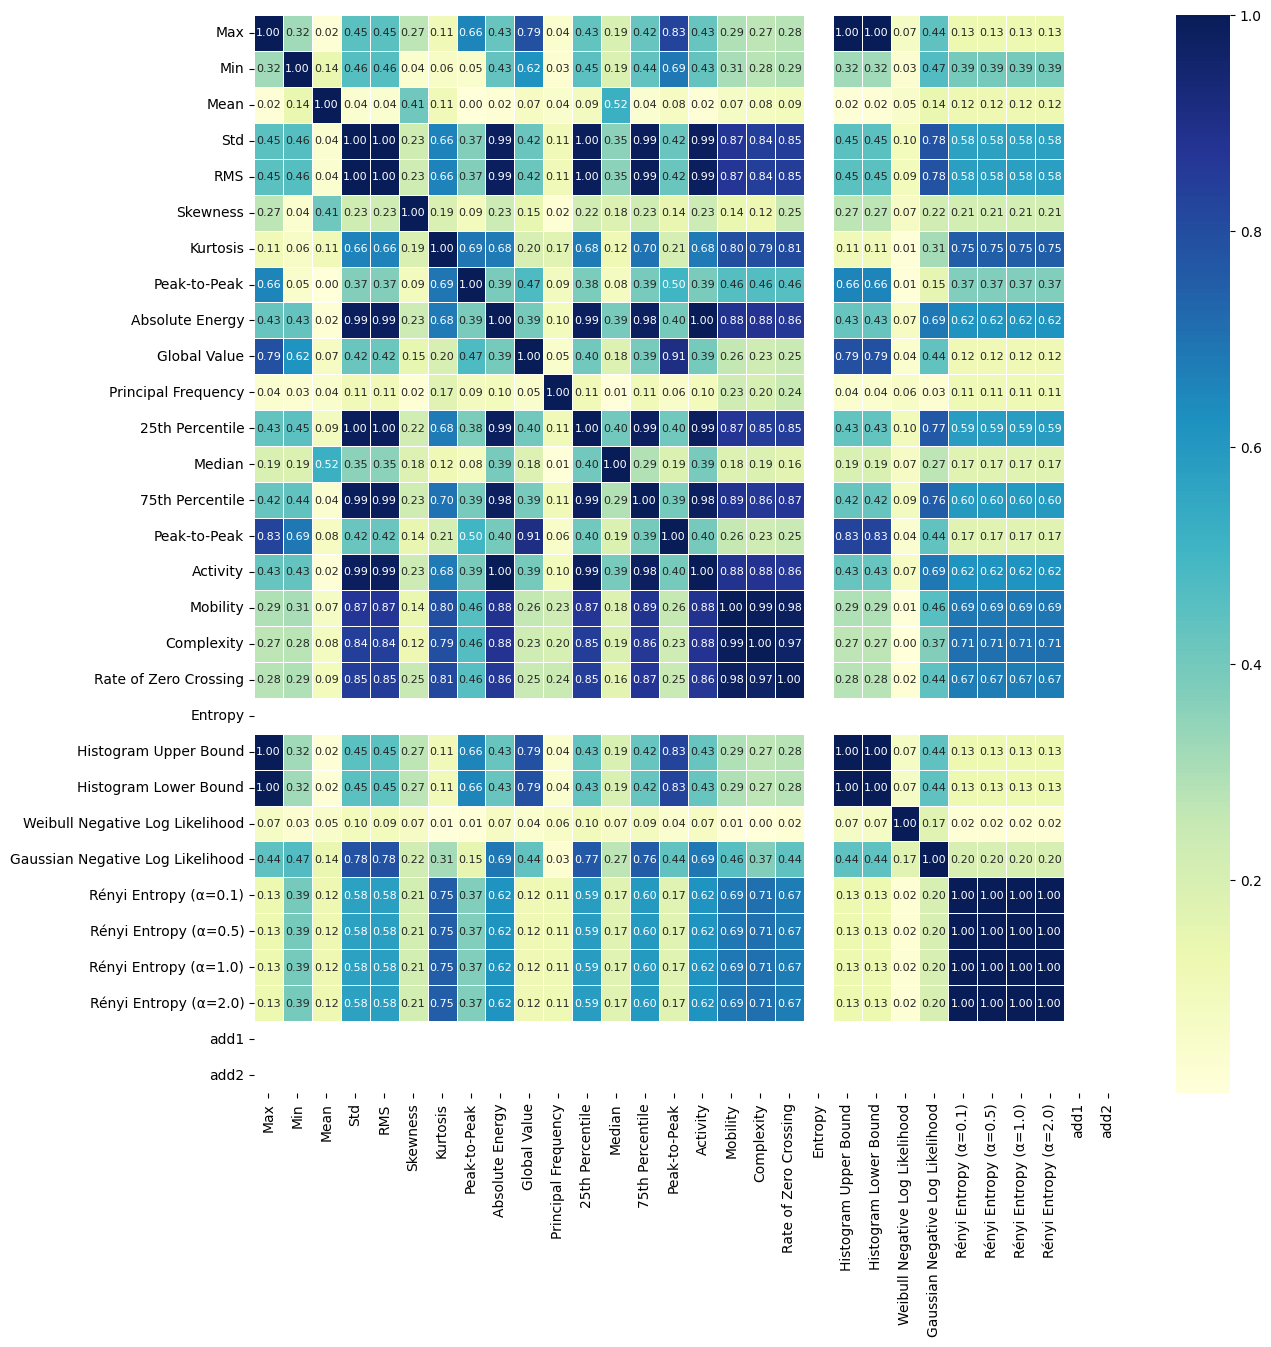

In [ ]:
#HEATMAPS
# Calculate the absolute correlation coefficients
corr = np.abs(All_new_feature_matrix.corr())

# Create a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# Set up the matplotlib figure
fig, ax = plt.subplots(figsize=(14, 14))

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, cmap="YlGnBu", annot=True, fmt=".2f",
            annot_kws={"size": 8}, linewidths=.5)

# Display the plot
plt.show()

/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:4527: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)
/usr/local/lib/python3.10/dist-packages/matplotlib/cbook/__init__.py:1257: RuntimeWarning: invalid value encountered in less_equal
  wiskhi = x[x <= hival]
/usr/local/lib/python3.10/dist-packages/matplotlib/cbook/__init__.py:1264: RuntimeWarning: invalid value encountered in greater_equal
  wisklo = x[x >= loval]
/usr/local/lib/python3.10/dist-packages/matplotlib/cbook/__init__.py:1272: RuntimeWarning: invalid value encountered in less
  x[x < stats['whislo']],
/usr/local/lib/python3.10/dist-packages/matplotlib/cbook/__init__.py:1273: RuntimeWarning: invalid value encountered in greater
  x[x > stats['whishi']],


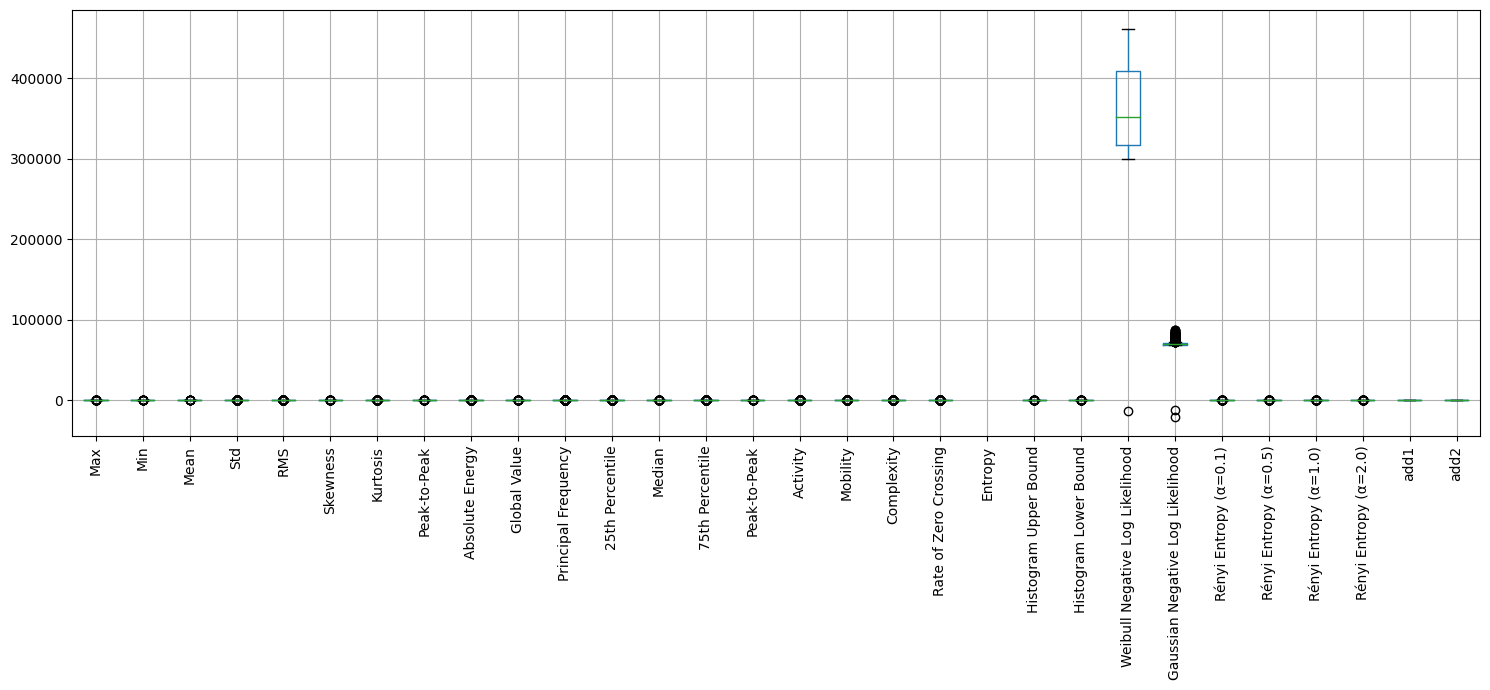

In [ ]:
#Box Plots
All_new_feature_matrix.boxplot(figsize=(15, 7), rot=90)
plt.tight_layout()
plt.show()

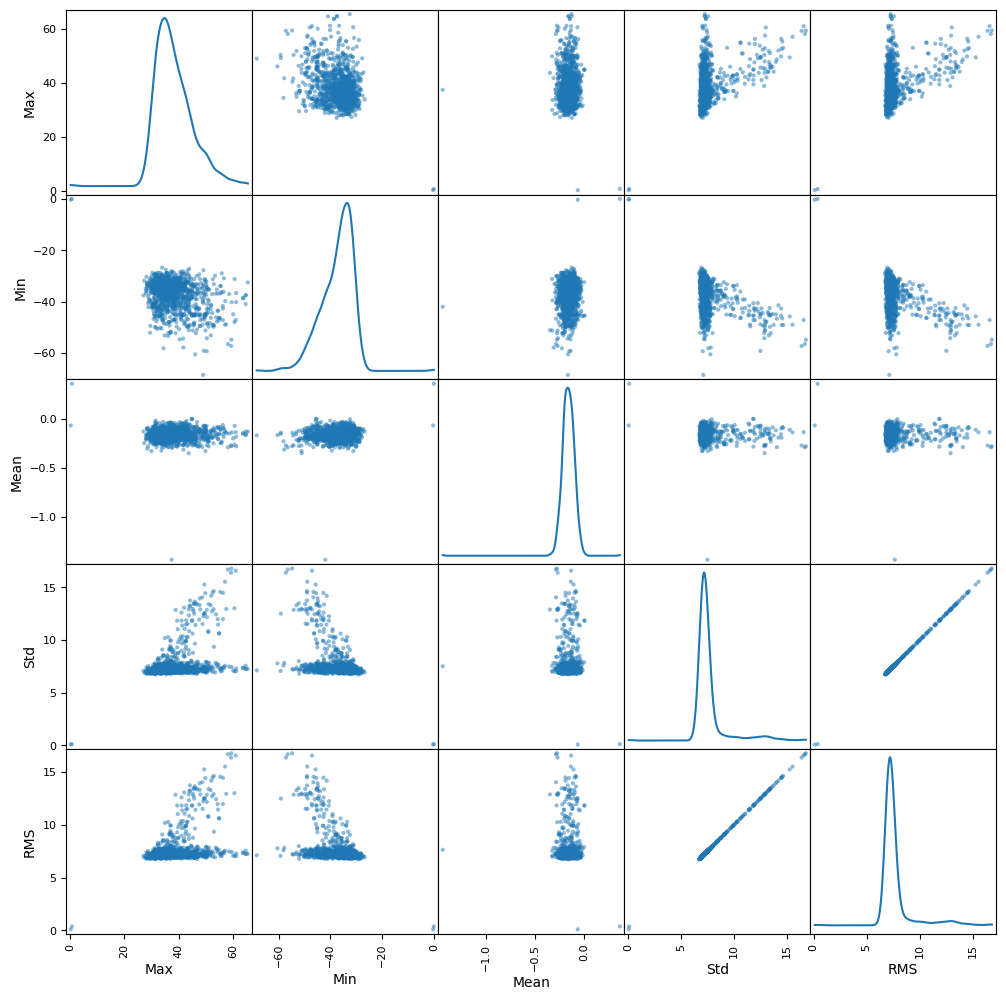

In [ ]:
from pandas.plotting import scatter_matrix

# Select a subset of columns
cols_subset = All_new_feature_matrix.columns[:5]  # Adjust as needed
scatter_matrix(All_new_feature_matrix[cols_subset], figsize=(12, 12), diagonal='kde')
plt.show()

In [4]:
print(os.listdir(path))

['2004.02.14.23.12.txt', '2004.02.15.13.42.txt', '2004.02.12.21.52.txt', '2004.02.14.17.22.txt', '2004.02.15.06.12.txt', '2004.02.13.09.42.txt', '2004.02.17.00.02.txt', '2004.02.17.09.02.txt', '2004.02.16.17.32.txt', '2004.02.13.11.42.txt', '2004.02.16.21.12.txt', '2004.02.15.05.32.txt', '2004.02.14.01.42.txt', '2004.02.14.15.52.txt', '2004.02.18.07.42.txt', '2004.02.12.23.02.txt', '2004.02.16.09.22.txt', '2004.02.12.23.32.txt', '2004.02.15.23.42.txt', '2004.02.13.08.32.txt', '2004.02.14.01.52.txt', '2004.02.17.15.42.txt', '2004.02.17.15.52.txt', '2004.02.18.20.02.txt', '2004.02.19.05.12.txt', '2004.02.13.04.02.txt', '2004.02.14.10.12.txt', '2004.02.17.15.12.txt', '2004.02.16.22.02.txt', '2004.02.12.18.22.txt', '2004.02.15.21.02.txt', '2004.02.13.02.02.txt', '2004.02.16.20.12.txt', '2004.02.14.03.12.txt', '2004.02.16.05.12.txt', '2004.02.13.06.12.txt', '2004.02.12.21.42.txt', '2004.02.15.09.52.txt', '2004.02.13.12.42.txt', '2004.02.12.12.42.txt', '2004.02.17.05.32.txt', '2004.02.15.22.

ValueError: ignored

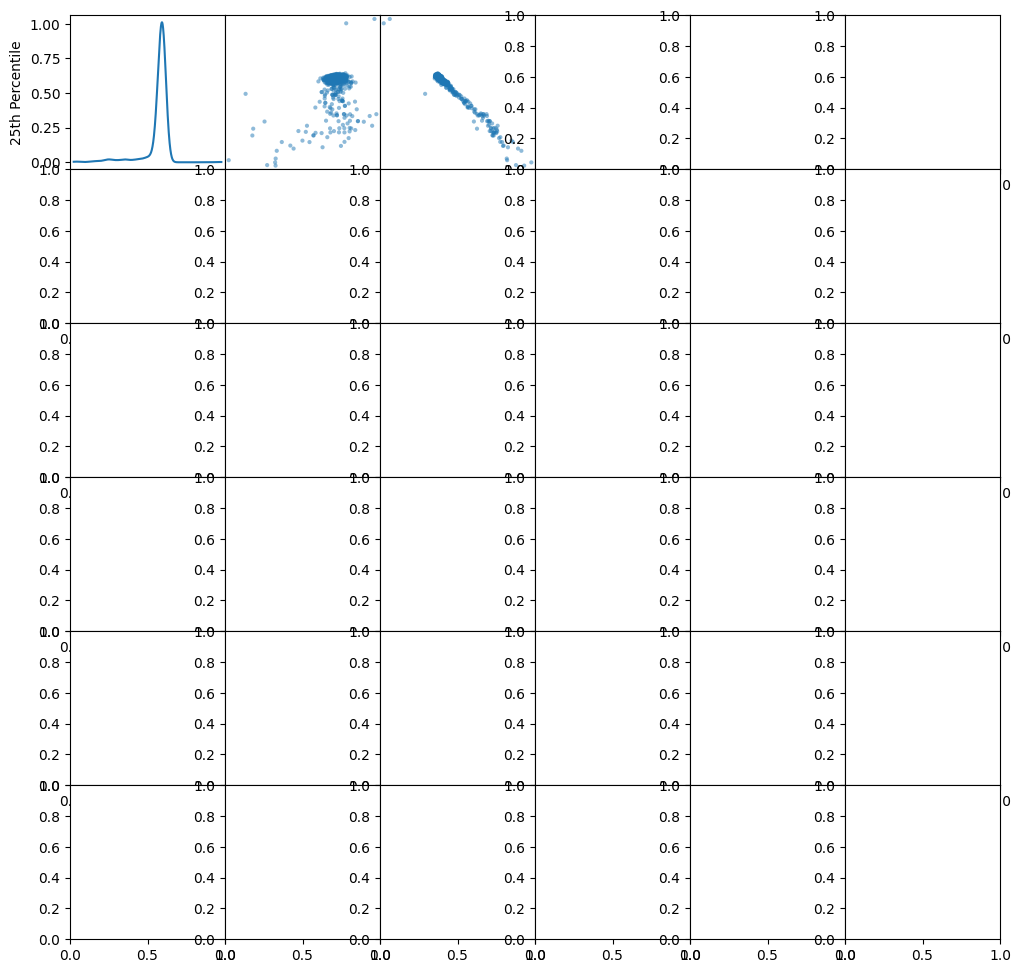

In [ ]:
# Select a subset of columns
cols_subset = All_new_feature_matrix.columns[11:16]  # Adjust as needed
scatter_matrix(All_new_feature_matrix[cols_subset], figsize=(12, 12), diagonal='kde')
plt.show()

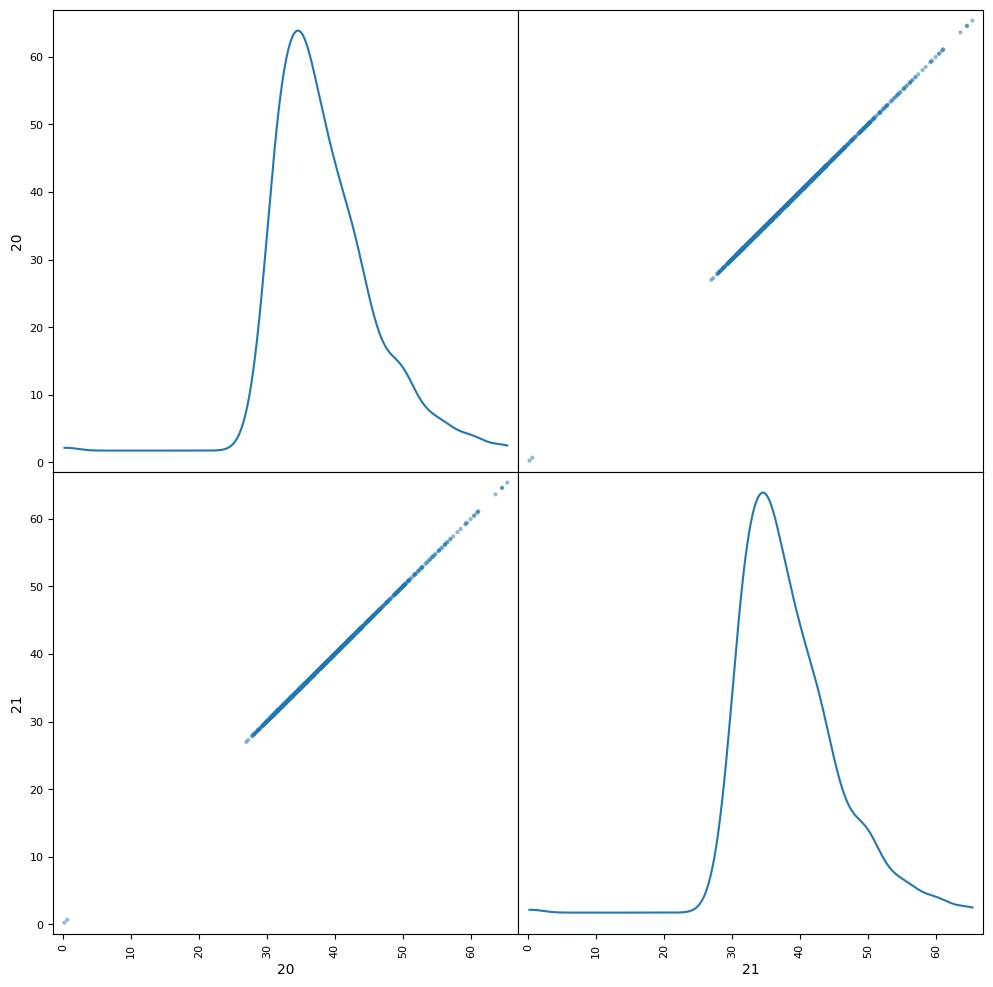

In [ ]:
# Select a subset of columns
cols_subset = All_new_feature_matrix.columns[20:22]  # Adjust as needed
scatter_matrix(All_new_feature_matrix[cols_subset], figsize=(12, 12), diagonal='kde')
plt.show()

In [ ]:
'''# Spectrograms
f_original, t_original, Sxx_original = spectrogram(vibration_data, fs=1.0/(t[1]-t[0]))
f_reconstructed, t_reconstructed, Sxx_reconstructed = spectrogram(reconstructed_signal, fs=1.0/(t[1]-t[0]))
frequencies_spectrum = np.fft.fftfreq(len(t), t[1]-t[0])
original_spectrum = np.fft.fft(vibration_data)
reconstructed_spectrum = np.fft.fft(reconstructed_signal)'''

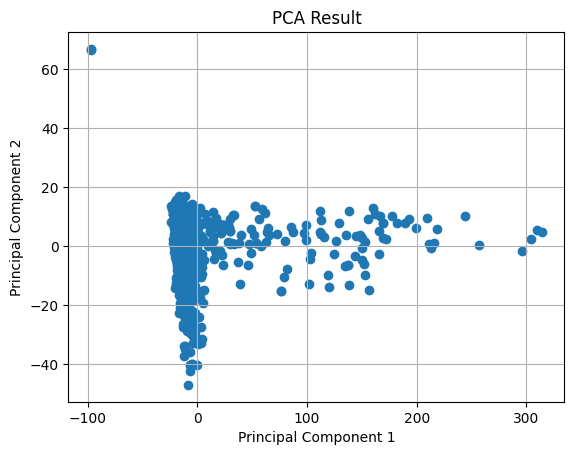

In [ ]:
from sklearn.decomposition import PCA
#pCA
pca = PCA(n_components=2)
reduced_data = pca.fit_transform(All_new_feature_matrix.iloc[:, :18])

plt.scatter(reduced_data[:, 0], reduced_data[:, 1])
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('PCA Result')
plt.grid(True)
plt.show()


In [ ]:
plt.figure(figsize=(15,7))
sns.violinplot(data=All_new_feature_matrix.iloc[:, :18])
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()


ValueError: ignored

<Figure size 1500x700 with 0 Axes>

In [ ]:
'''
# Time-Domain Features
mean_signal = np.mean(vibration_data)
std_signal = np.std(vibration_data)
max_signal = np.max(vibration_data)
min_signal = np.min(vibration_data)
rms_signal = np.sqrt(np.mean(np.square(vibration_data)))
kurtosis_signal = np.mean((vibration_data - mean_signal)**4) / std_signal**4
skewness_signal = np.mean((vibration_data - mean_signal)**3) / std_signal**3
#add
median_signal = np.median(vibration_data)
zero_crossing_rate = np.sum(np.diff(np.sign(vibration_data)) != 0) / len(t)
entropy_signal = entropy(np.abs(vibration_data))
hist_upper_bound = np.max(vibration_data) + ((np.max(vibration_data) - np.min(vibration_data) / (len(t) - 1)) / 2)
hist_lower_bound = np.max(vibration_data) - ((np.max(vibration_data) - np.min(vibration_data) / (len(t) - 1)) / 2)
activity = np.sum(np.abs(np.diff(vibration_data)))
mobility = np.std(np.diff(vibration_data)) / np.std(vibration_data)
complexity = (mobility / activity) * (entropy_signal)
#added
# Frequency-Domain Features
peak_frequency = frequencies_spectrum[np.argmax(np.abs(original_spectrum))]
max_magnitude = np.max(np.abs(original_spectrum))
freq_at_max_magnitude = frequencies_spectrum[np.argmax(np.abs(original_spectrum))]'''

In [ ]:
'''# Printing extracted features
print("Time-Domain Features:")
print("Mean:", mean_signal)
print("Standard Deviation:", std_signal)
print("Maximum:", max_signal)
print("Minimum:", min_signal)
print("RMS:", rms_signal)
print("Kurtosis:", kur
tosis_signal)
print("Skewness:", skewness_signal)
#added
print("Median:", median_signal)
print("Zero Crossing Rate:", zero_crossing_rate)
print("Entropy:", entropy_signal)
print("Histogram Upper Bound T24:", hist_upper_bound)
print("Histogram Lower Bound T25:", hist_lower_bound)
print("Activity:", activity)
print("Mobility:", mobility)
print("Complexity:", complexity)
 #added
print("\nFrequency-Domain Features:")
print("Peak Frequency:", peak_frequency)
print("Maximum Magnitude in Frequency Spectrum:", max_magnitude)
print("Frequency at Maximum Magnitude:", freq_at_max_magnitude)'''

In [ ]:
'''#feature vector
feature_vector = np.array([
    mean_signal,
    median_signal,
    rms_signal,
    min_signal,
    std_signal,
    zero_crossing_rate,
    entropy_signal,
    skewness_signal,
    kurtosis_signal,
    hist_upper_bound,
    hist_lower_bound,
    activity,
    mobility,
    complexity
    # Add Weibull and Normal negative log likelihood features here
])
print("Feature Vector:")
print(feature_vector)'''

In [ ]:
plt.tight_layout()
plt.show()

<Figure size 640x480 with 0 Axes>